<a href="https://colab.research.google.com/github/iffigueroa/Satellite-Classification/blob/main/supervised_satellite_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Use Classification | Supervised Learning Approach

## Problem Overview

This project focuses on classifying the purpose of satellites using data provided by the UCS organization. The goal is to explore and test supervised learning approaches, specifically K-Nearest Neighbors (KNN) and Decision Trees, to predict a satellite's purpose based on a set of features.

The project aims to identify the most influential features for predicting a satellite's purpose. Additionally, it seeks to address issues of biased data by implementing strategies to mitigate bias in the classification process. This research not only enhances our understanding of satellite usage but also contributes to the development of more accurate and unbiased classification models.

## About the dataset

The dataset I'll be using for this project was compiled by the Union of Concerned Scientists (UCS) from several sources. The dataset contains information about various satellites that are currently or have been in orbit.

The dataset is available here: https://www.ucsusa.org/resources/satellite-database

# Exploratory Data Analysis (EDA) & Data Preparation

In this section we'll be performing some initial analysis on the data we are going to be working with. In general we'll take a look at the available attributes to see what they look like and their distributions.

Preliminary data cleaning has already been completed in the `data_cleaning` notebook. However there are a few additional steps we'll need to take to prepare the data specifically to enter the supervised model we'll be building later on.

As a summary here are the steps we'll take in this section:
- Visualize the data available for each attribute
- Set up label encodings for text-based data for entering the model


## Loading the Data
Here we load the clean data output from the `data_cleaning` notebook.

In [ ]:
import pandas as pd

sat_df = pd.read_csv('satellite_db_clean.csv')
sat_df.head()

Country of Operator/Owner       Users                 Purpose  \
0                       USA  COMMERCIAL       EARTH OBSERVATION   
1            UNITED KINGDOM  COMMERCIAL       EARTH OBSERVATION   
2                   FINLAND       CIVIL  TECHNOLOGY DEVELOPMENT   
3                   DENMARK       CIVIL       EARTH OBSERVATION   
4             MULTINATIONAL  COMMERCIAL          COMMUNICATIONS   

        Type of Orbit  Longitude of GEO (degrees)  Perigee (km)  Apogee (km)  \
0  NON-POLAR INCLINED                         0.0         566.0        576.0   
1     SUN-SYNCHRONOUS                         0.0         637.0        654.0   
2     SUN-SYNCHRONOUS                         0.0         497.0        517.0   
3     SUN-SYNCHRONOUS                         0.0         442.0        687.0   
4          EQUATORIAL                        75.0       35778.0      35793.0   

   Eccentricity  Inclination (degrees)  Period (minutes)  Launch Mass (kg.)  \
0      0.001510                  36.90             96.08               22.0   
1      0.001510                  98.00             95.00                4.0   
2      0.001450                  97.45             94.70                4.5   
3      0.001510                  98.20             95.90                1.0   
4      0.000178                   0.08           1436.03             6330.0   

                  Launch Site Launch Vehicle Date of Launch  \
0  SATISH DHAWAN SPACE CENTER           PSLV     2019-12-11   
1              CAPE CANAVERAL       FALCON 9     2023-01-03   
2  SATISH DHAWAN SPACE CENTER           PSLV     2017-06-23   
3         GUIANA SPACE CENTER     SOYUZ-2.1A     2016-04-25   
4         GUIANA SPACE CENTER   ARIANE 5 ECA     2014-02-06   

           Purpose_subset  
0       EARTH OBSERVATION  
1       EARTH OBSERVATION  
2  TECHNOLOGY DEVELOPMENT  
3       EARTH OBSERVATION  
4          COMMUNICATIONS

In [ ]:
print(f"This dataset has {sat_df.shape[0]} entries and {sat_df.shape[1]} attributes.")
print(f"Available Attributes:\n\n{sat_df.dtypes}")

This dataset has 7201 entries and 15 attributes.
Available Attributes:

Country of Operator/Owner      object
Users                          object
Purpose                        object
Type of Orbit                  object
Longitude of GEO (degrees)    float64
Perigee (km)                  float64
Apogee (km)                   float64
Eccentricity                  float64
Inclination (degrees)         float64
Period (minutes)              float64
Launch Mass (kg.)             float64
Launch Site                    object
Launch Vehicle                 object
Date of Launch                 object
Purpose_subset                 object
dtype: object


In [ ]:
# Set date to correct type
sat_df['Date of Launch'] = pd.to_datetime(sat_df['Date of Launch'])

## Helper Functions for Data Visualization

In [ ]:
from re import U
import pandas as pd
import matplotlib.pyplot as plt
# Helpers
def plot_top_n_histogram(df, column_name, n):
    # Get the unique values and their counts
    value_counts = df[column_name].value_counts()

    # If there are more than n unique values, take the top n
    if len(value_counts) > n:
        value_counts = value_counts.head(n)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    # value_counts.plot(kind='hist', density=True)
    (value_counts / len(df)).plot(kind='bar')
    plt.xlabel(f'{column_name} Values')
    plt.ylabel('Density')
    plt.title(f'Top {n} values in {column_name}')
    plt.xticks(rotation=90)
    plt.show()

def box_plot(df: pd.DataFrame, column: str):
  boxplot = df.boxplot(column=column, showfliers=False)
  plt.ylabel(f'{column} Value')
  plt.title(f'Box Plot of {column} Values')
  plt.show()

def plot_dates(df: pd.DataFrame, column: str):
  launches_per_year = df.groupby(df[column].dt.year).size()
  launches_per_year.plot(kind='bar', xlabel='Year', ylabel='Number of Launches', title='Launches by Year')
  plt.show()

def column_overview(df: pd.DataFrame, column: str, show_plot: bool = False, n:int = 50) -> None:
    print(f"Column: {column}")
    print(f"Type: {df[column].dtype}")
    unique_values = df[column].unique()
    print(f"Found {len(unique_values)} unique values")
    if show_plot:
        if df[column].dtype == 'datetime64[ns]':
          plot_dates(df, column)
        elif df[column].dtype == 'float64':
          box_plot(df, column)
        else:
          num_values = len(df[column].unique())
          if num_values < n:
            n = num_values
          plot_top_n_histogram(df, column, n=n)
    else:
      try:
        unique_values = sorted(df[column].unique().tolist())
        print(unique_values)
      except Exception:
        print(unique_values)


## Exploratory Data Analysis

In this section I'll generate a handful of plots to get an idea for what data is available and for how the data are distributed.

Column: Country of Operator/Owner
Type: object
Found 102 unique values


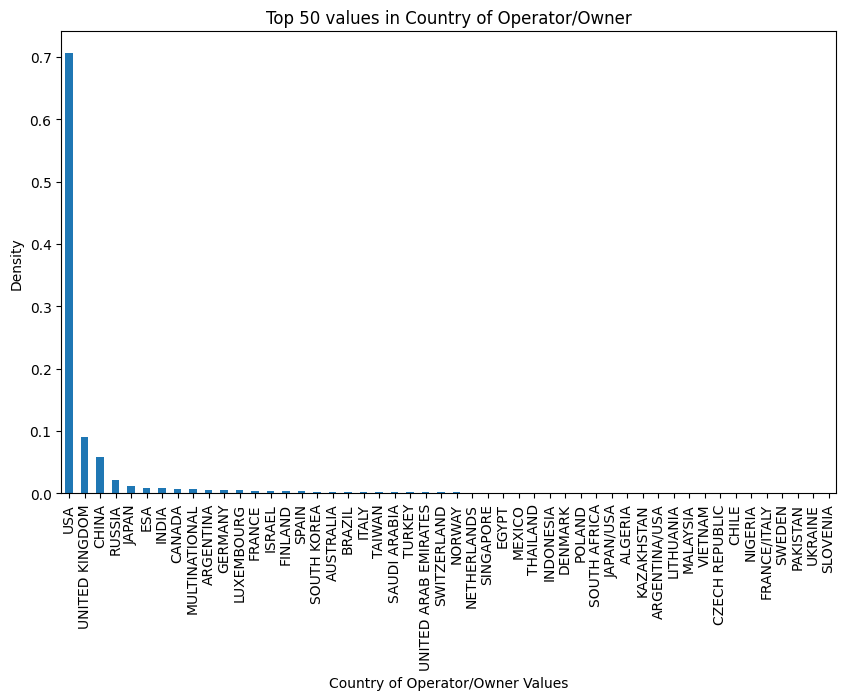

Column: Users
Type: object
Found 11 unique values


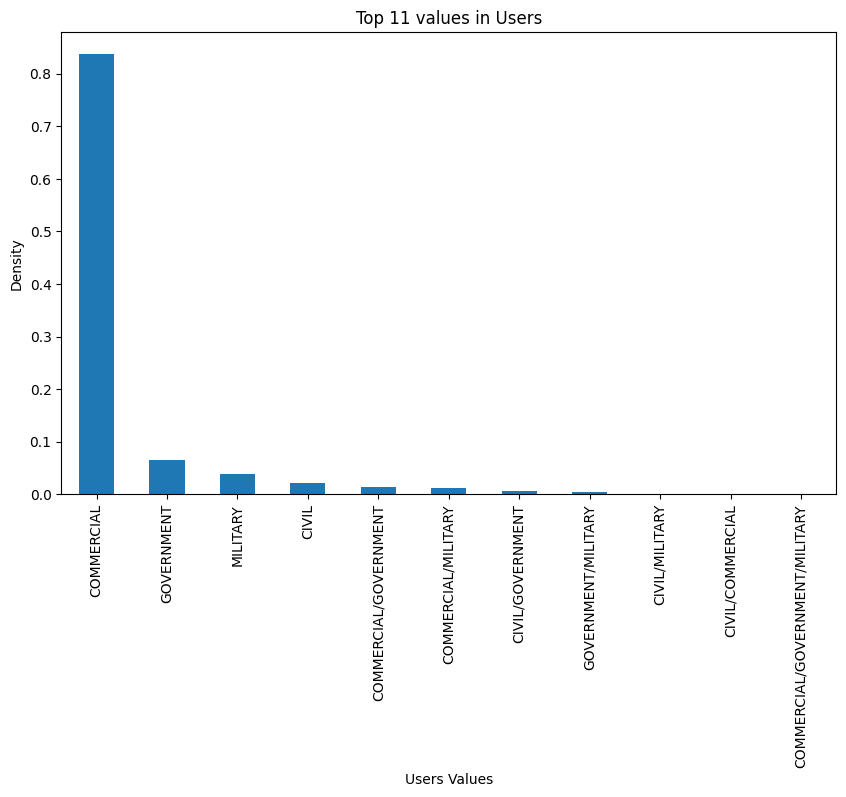

Column: Purpose
Type: object
Found 29 unique values


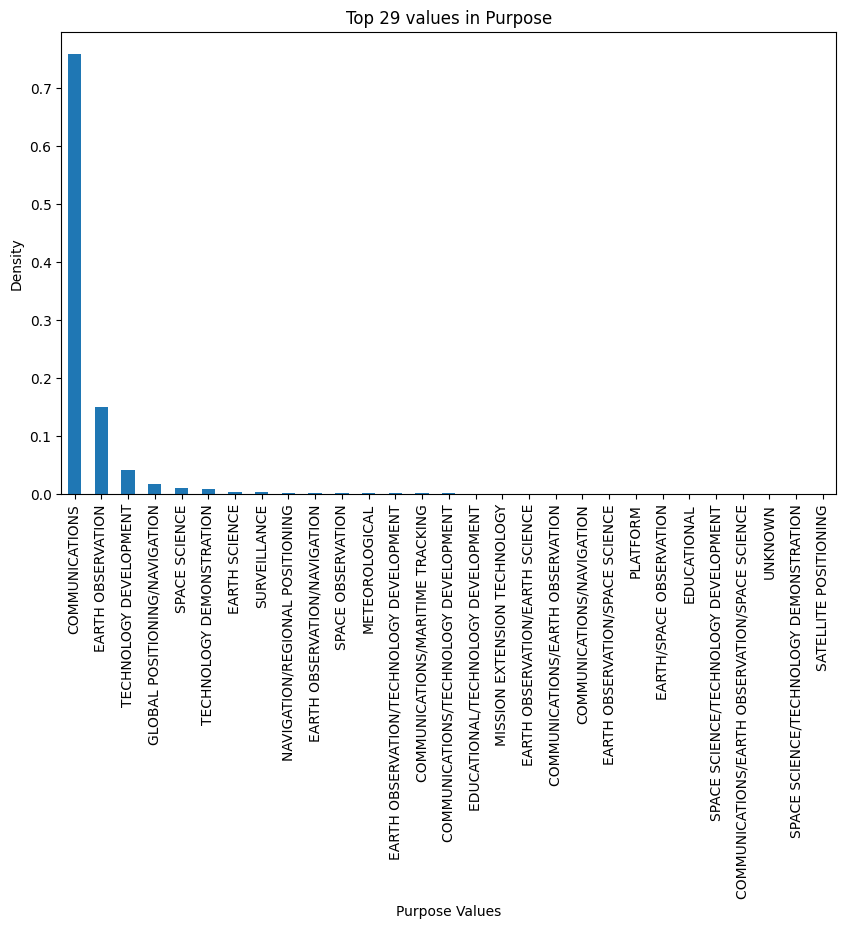

Column: Type of Orbit
Type: object
Found 10 unique values


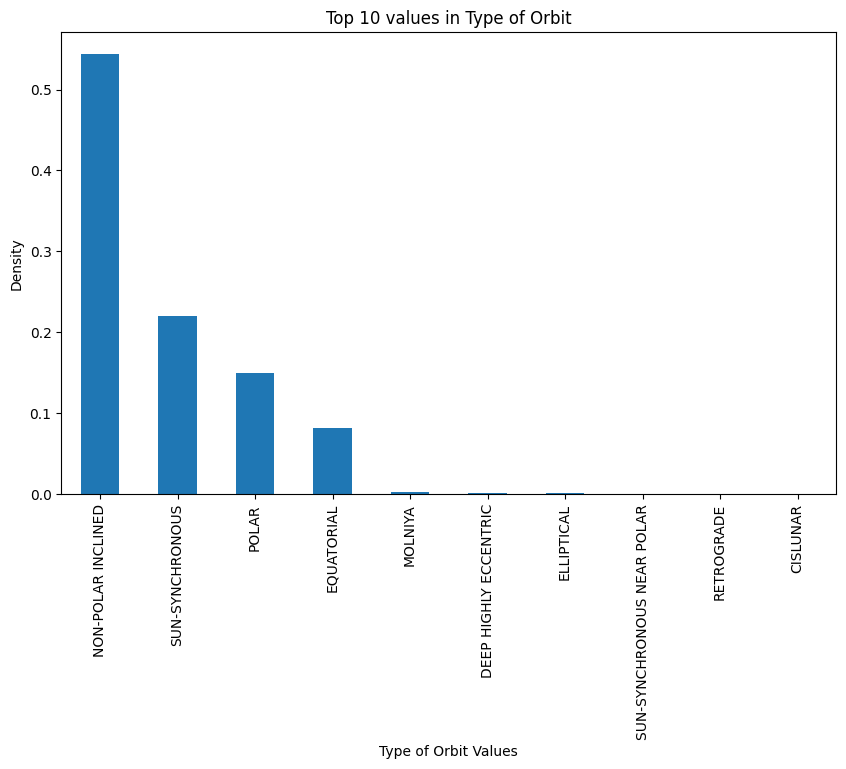

Column: Longitude of GEO (degrees)
Type: float64
Found 422 unique values


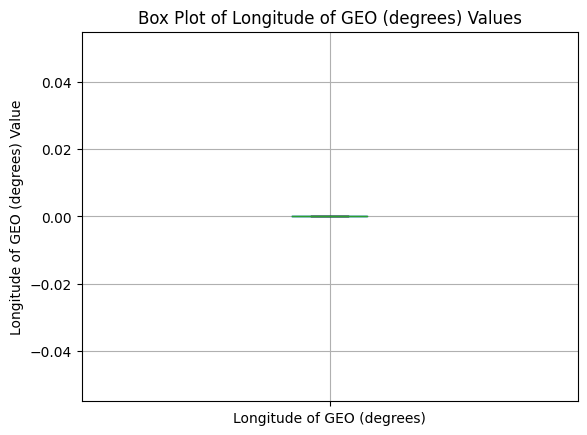

Column: Perigee (km)
Type: float64
Found 713 unique values


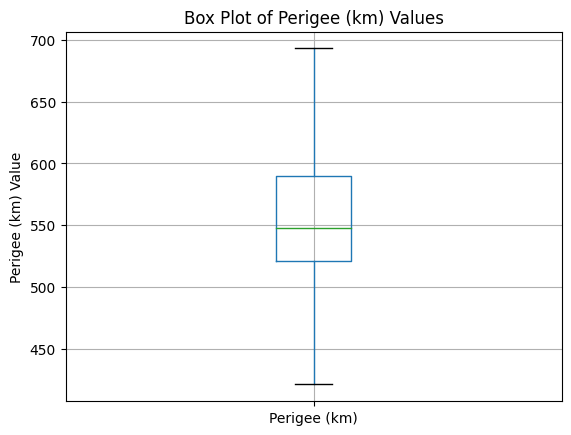

Column: Apogee (km)
Type: float64
Found 699 unique values


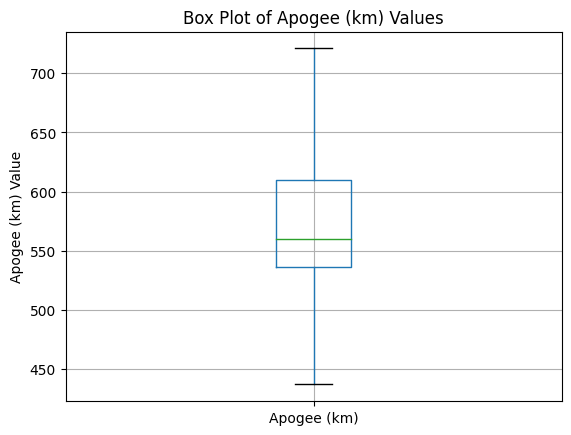

Column: Eccentricity
Type: float64
Found 1654 unique values


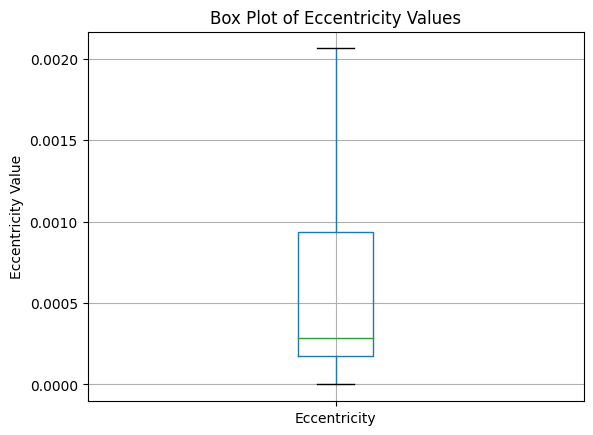

Column: Inclination (degrees)
Type: float64
Found 395 unique values


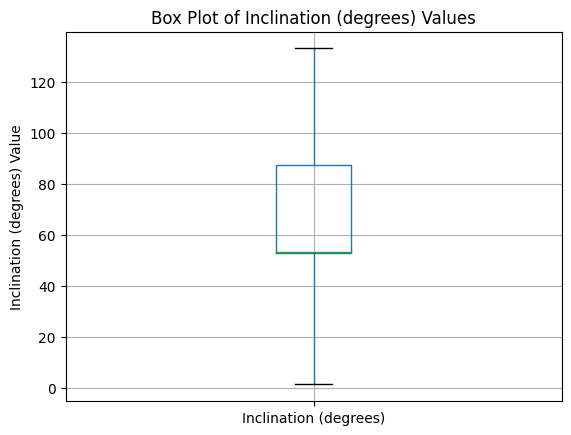

Column: Period (minutes)
Type: float64
Found 513 unique values


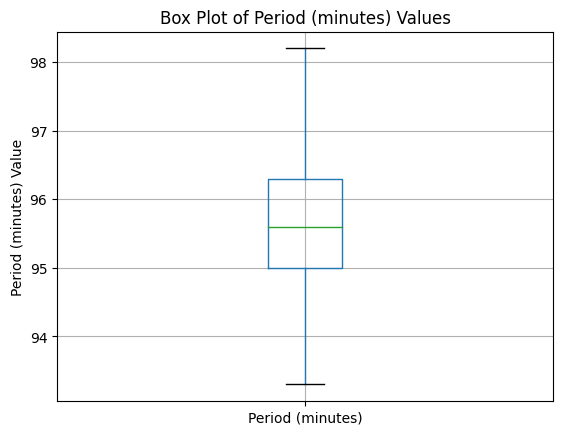

Column: Launch Mass (kg.)
Type: float64
Found 586 unique values


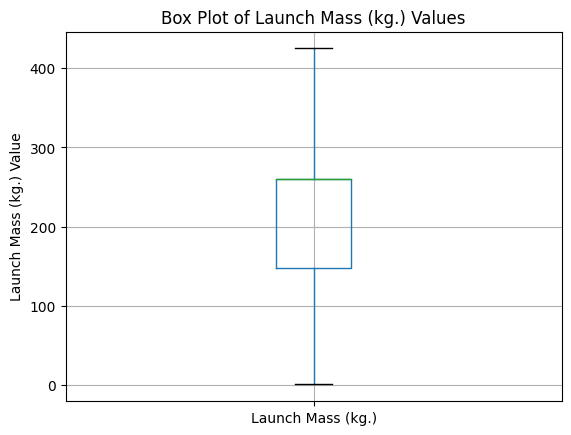

Column: Launch Site
Type: object
Found 38 unique values


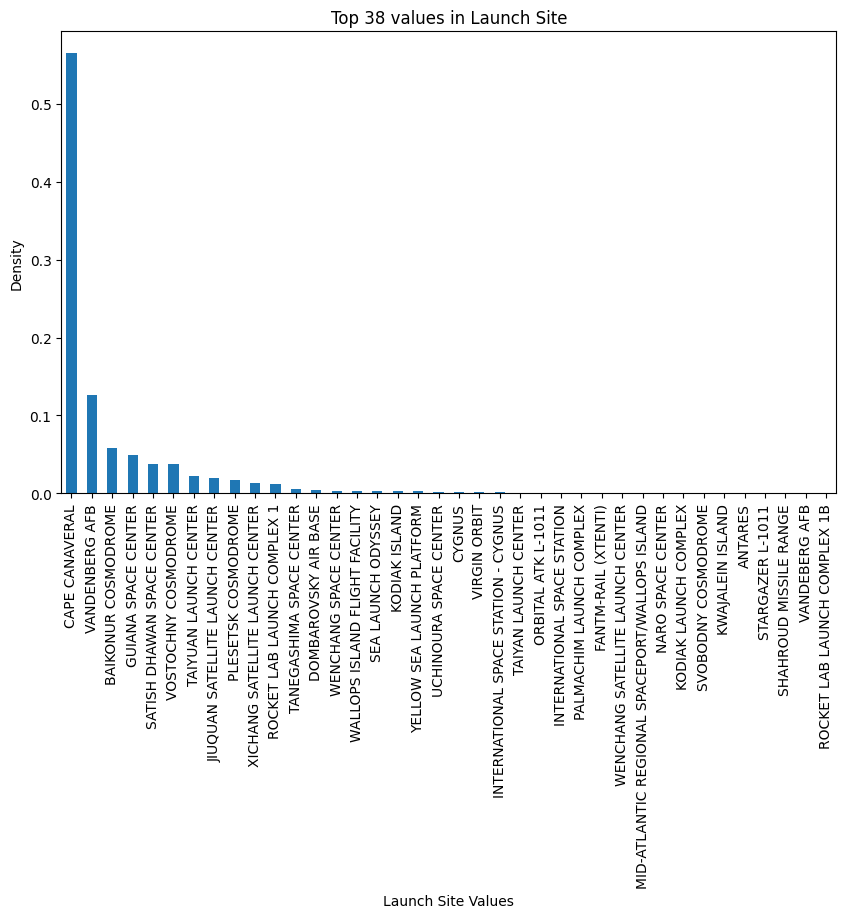

Column: Launch Vehicle
Type: object
Found 155 unique values


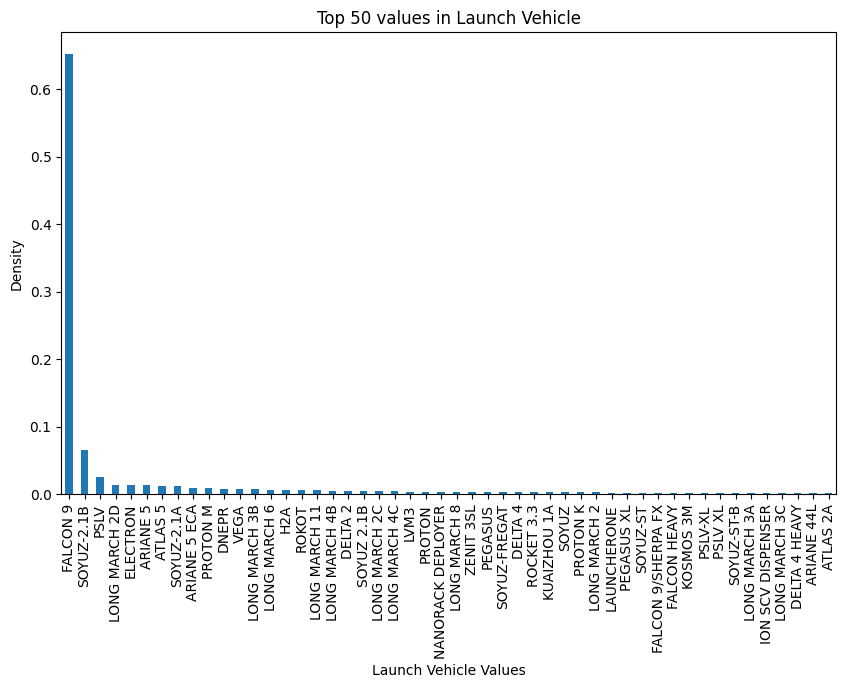

Column: Date of Launch
Type: datetime64[ns]
Found 1089 unique values


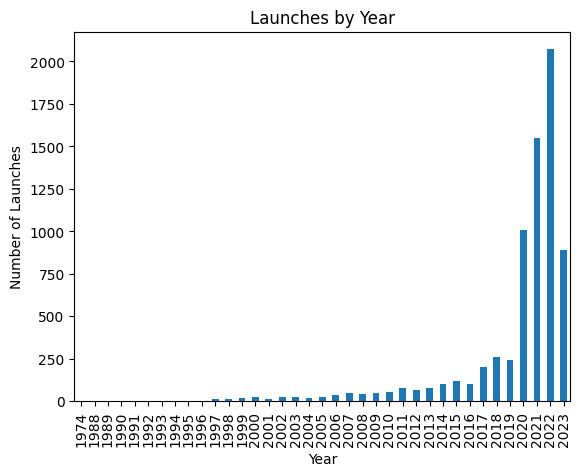

Column: Purpose_subset
Type: object
Found 16 unique values


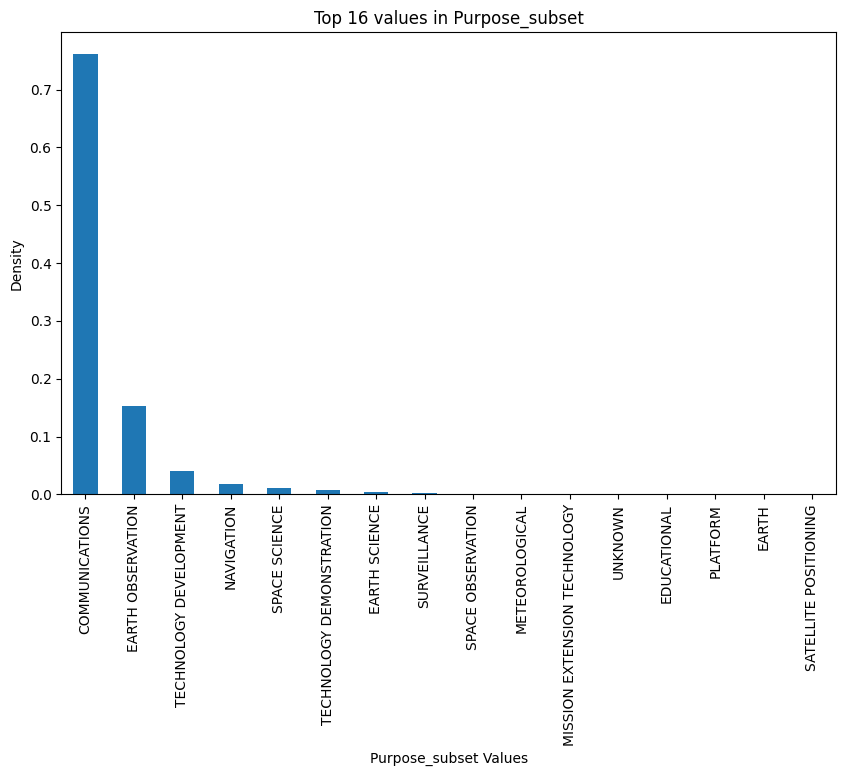

In [ ]:
for column in sat_df.columns:
  column_overview(sat_df, column, show_plot=True)

## Data Preparation
While the data has been cleaned already, we need to prepare the data to enter the models we'll be developing. In general, models don't work well with text based data unless you are creating an NLP model, so in this section we'll be creating label encodings for the text-based attributes we have to work with.


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_mappings = {} # Used to keep track of mappings in case we need them later
categorical_feats = []
for col in sat_df.columns:
    if sat_df[col].dtype == 'object':
        sat_df[f'{col}_encoded'] = le.fit_transform(sat_df[col])
        sat_df[col] = pd.Categorical(sat_df[col])
        class_mapping = {index: label for index, label in enumerate(le.classes_)}
        encoded_mappings[col] = class_mapping
        categorical_feats.append(col)

## Exploring Correlations of Remaining Attributes

With the next snippit of code below we can take a look at the correlations between attributes - note that only the encoded/numerical values are shown since that is how they have to enter our model.

We see that there are a few pockets of values that do appear to have a strong correlation, for example Perigee and Apogee, Period and Launch Mass, as well as country of Contractor, Operator/Owner, and UN Registry. All of which make sense given the context.

If we look at

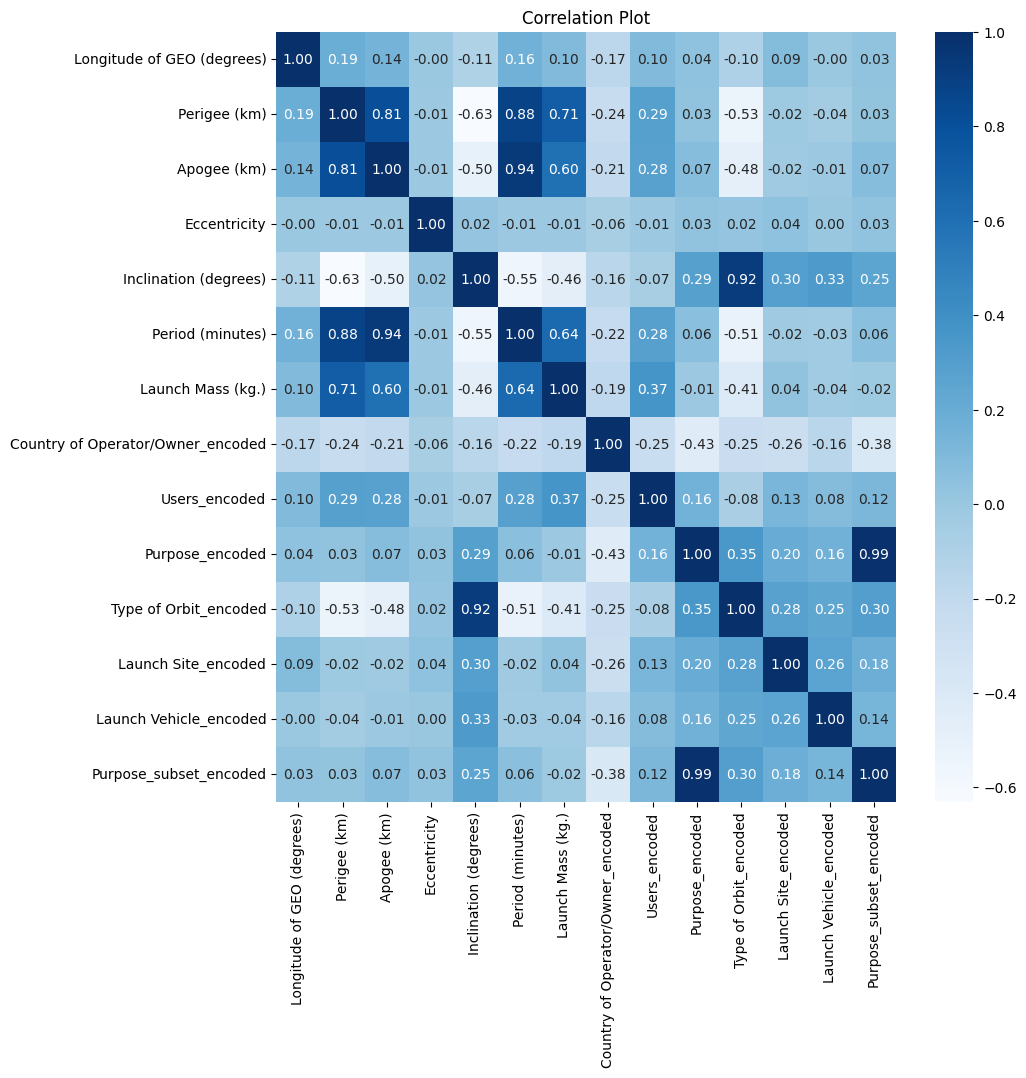

In [ ]:
import seaborn as sns
corr = sat_df.corr(numeric_only=True)

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

If we look at the correlations for our Target value, we can see there appear to be stronger correlations with Type of Orbit, Inclination and Launch Site. This may come in handy when we move on to feature selection.

In [ ]:
purpose_corr_values = corr['Purpose_encoded'].sort_values(ascending=False)
print(purpose_corr_values)

Purpose_encoded                      1.000000
Purpose_subset_encoded               0.990177
Type of Orbit_encoded                0.350043
Inclination (degrees)                0.289165
Launch Site_encoded                  0.198725
Launch Vehicle_encoded               0.160767
Users_encoded                        0.157431
Apogee (km)                          0.073512
Period (minutes)                     0.062687
Longitude of GEO (degrees)           0.038667
Eccentricity                         0.034765
Perigee (km)                         0.033293
Launch Mass (kg.)                   -0.008010
Country of Operator/Owner_encoded   -0.427241
Name: Purpose_encoded, dtype: float64


# Model Building

In this section we will build two types of supervised models: Decision Tree Classifiers and KNN classifiers. The goal is to see if we can reliably classify Satellite use based on some factors to be determined. First we'll perform preliminary feature selection based on a combination of correlation + iterating through feature choices to see which produce highest accuracy. After we'll build our models and apply different methods to try and negate biases in our data.


In [ ]:
# During model building we'll track model performance with the results df
models = []
results = pd.DataFrame(columns=['DataFrame', 'Model', 'Features', 'Target', 'Accuracy'])

def add_to_results(df_name, model, model_type, features, target, accuracy):
  global results
  new_row = {'DataFrame':df_name,'Model': model_type, 'Features': features, 'Target': target, 'Accuracy':accuracy}
  models.append(model)
  results.loc[len(results)] = new_row



## Decision Tree Models

In this section, we'll start building decision tree models, which are a type of supervised learning model. Decision trees partition the feature space into subsets and assign class values to each subset based on the dataset's information. They exhibit a hierarchical, tree-like structure, where each branch leads to a decision point guiding the classification process. As we navigate through the tree, answering questions about our data, we eventually reach a leaf node that provides the final classification.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from typing import Optional, List

def get_confusion_matrix(y_test, y_pred, labels: Optional[List[str]] = None):
  plt.figure(figsize=(12, 12))
  if labels:
    cm = confusion_matrix(y_test, y_pred, labels = labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
  else:
    cm = confusion_matrix(y_test, y_pred, labels = labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()


def build_and_eval_decision_tree(df: pd.DataFrame, df_name: str, features: List[str], target: str, target_encoding: Optional[dict] = None, show_results:bool=True):
  X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=55)
  clf = DecisionTreeClassifier(random_state=55)
  clf.fit(X_train, y_train)

  # Evaluating model performance
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  if show_results:
    print(f"Accuracy: {accuracy}")
    if target_encoding:
      # Map the values back to original string values
      y_pred_decoded = [target_encoding[encoded_value] for encoded_value in y_pred]
      y_test_decided = [target_encoding[encoded_value] for encoded_value in y_test]
      labels = list(target_encoding.values())
      get_confusion_matrix(y_test_decided, y_pred_decoded, labels)
    else:
      get_confusion_matrix(y_test, y_pred)

  add_to_results(
    df_name = df_name,
    model = clf,
    model_type = "Decision Tree",
    features=features,
    target = target,
    accuracy = accuracy
  )


## Feature selection
To get started with a first pass at feature selection we can use a correlation plot created in the last section. We can start to get an idea of which attributes may have some influence in predicting the a satellite's purpose. Of course, `Purpose` and `Purpose_subset` have a high correlation because that is our target value, so that will obviously not be used. However we can see that

 to see which values might be related to and influencing the attribute we want to predict (`Purpose`). Using the code below we can visualize the correlation plot.

In [ ]:
# Choose top features - removes purpose & purpose encoded
top_features = corr['Purpose_encoded'].sort_values(ascending=False)[2:9]
print(top_features)
top_features = top_features.index.tolist()

Type of Orbit_encoded     0.350043
Inclination (degrees)     0.289165
Launch Site_encoded       0.198725
Launch Vehicle_encoded    0.160767
Users_encoded             0.157431
Apogee (km)               0.073512
Period (minutes)          0.062687
Name: Purpose_encoded, dtype: float64


In [ ]:
from itertools import combinations
# make sure we start with a clean model + results list (in case we're re-running)
models = []
results = pd.DataFrame(columns=['DataFrame', 'Model', 'Features', 'Target', 'Accuracy'])

# iterate through feature combinations
n = len(top_features)+1
feature_combos = [list(feature_combo) for r in range(1, n) for feature_combo in combinations(top_features, r)]
print(f"Testing {len(feature_combos)} feature combinations.")
for features in feature_combos:
  build_and_eval_decision_tree(
    df = sat_df,
    df_name = 'sat_df',
    features = features,
    target = "Purpose_encoded",
    target_encoding=encoded_mappings['Purpose'],
    show_results=False
)

Testing 127 feature combinations.


In [ ]:
sorted_results = results.sort_values(by='Accuracy', ascending=False)
sorted_results.head(10)

DataFrame          Model  \
80     sat_df  Decision Tree   
90     sat_df  Decision Tree   
105    sat_df  Decision Tree   
51     sat_df  Decision Tree   
120    sat_df  Decision Tree   
71     sat_df  Decision Tree   
109    sat_df  Decision Tree   
117    sat_df  Decision Tree   
124    sat_df  Decision Tree   
114    sat_df  Decision Tree   

                                              Features           Target  \
80   [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_encoded   
90   [Inclination (degrees), Launch Vehicle_encoded...  Purpose_encoded   
105  [Type of Orbit_encoded, Inclination (degrees),...  Purpose_encoded   
51   [Inclination (degrees), Users_encoded, Period ...  Purpose_encoded   
120  [Type of Orbit_encoded, Inclination (degrees),...  Purpose_encoded   
71   [Type of Orbit_encoded, Inclination (degrees),...  Purpose_encoded   
109  [Type of Orbit_encoded, Launch Site_encoded, L...  Purpose_encoded   
117  [Inclination (degrees), Launch Vehicle_encoded...  Purpose_encoded   
124  [Type of Orbit_encoded, Launch Site_encoded, L...  Purpose_encoded   
114  [Inclination (degrees), Launch Site_encoded, L...  Purpose_encoded   

     Accuracy  
80   0.913255  
90   0.913255  
105  0.911173  
51   0.910479  
120  0.910479  
71   0.910479  
109  0.909785  
117  0.909091  
124  0.909091  
114  0.909091

In [ ]:
max_accuracy_row = results.loc[results['Accuracy'].idxmax()]
model_features = max_accuracy_row['Features']
print(f"Best model features: {model_features}")

Best model features: ['Type of Orbit_encoded', 'Launch Vehicle_encoded', 'Users_encoded', 'Period (minutes)']


Above is the optimal set of features from the run of various permutations, we'll continue testing a few models with these features.

In [ ]:
# start new model evaluation with a clean model + results lists
models = []
results = pd.DataFrame(columns=['DataFrame', 'Model', 'Features', 'Target', 'Accuracy'])

## Model One: Basic

Now that we've picked our model features, lets evaluate the model.

Accuracy: 0.9132546842470507


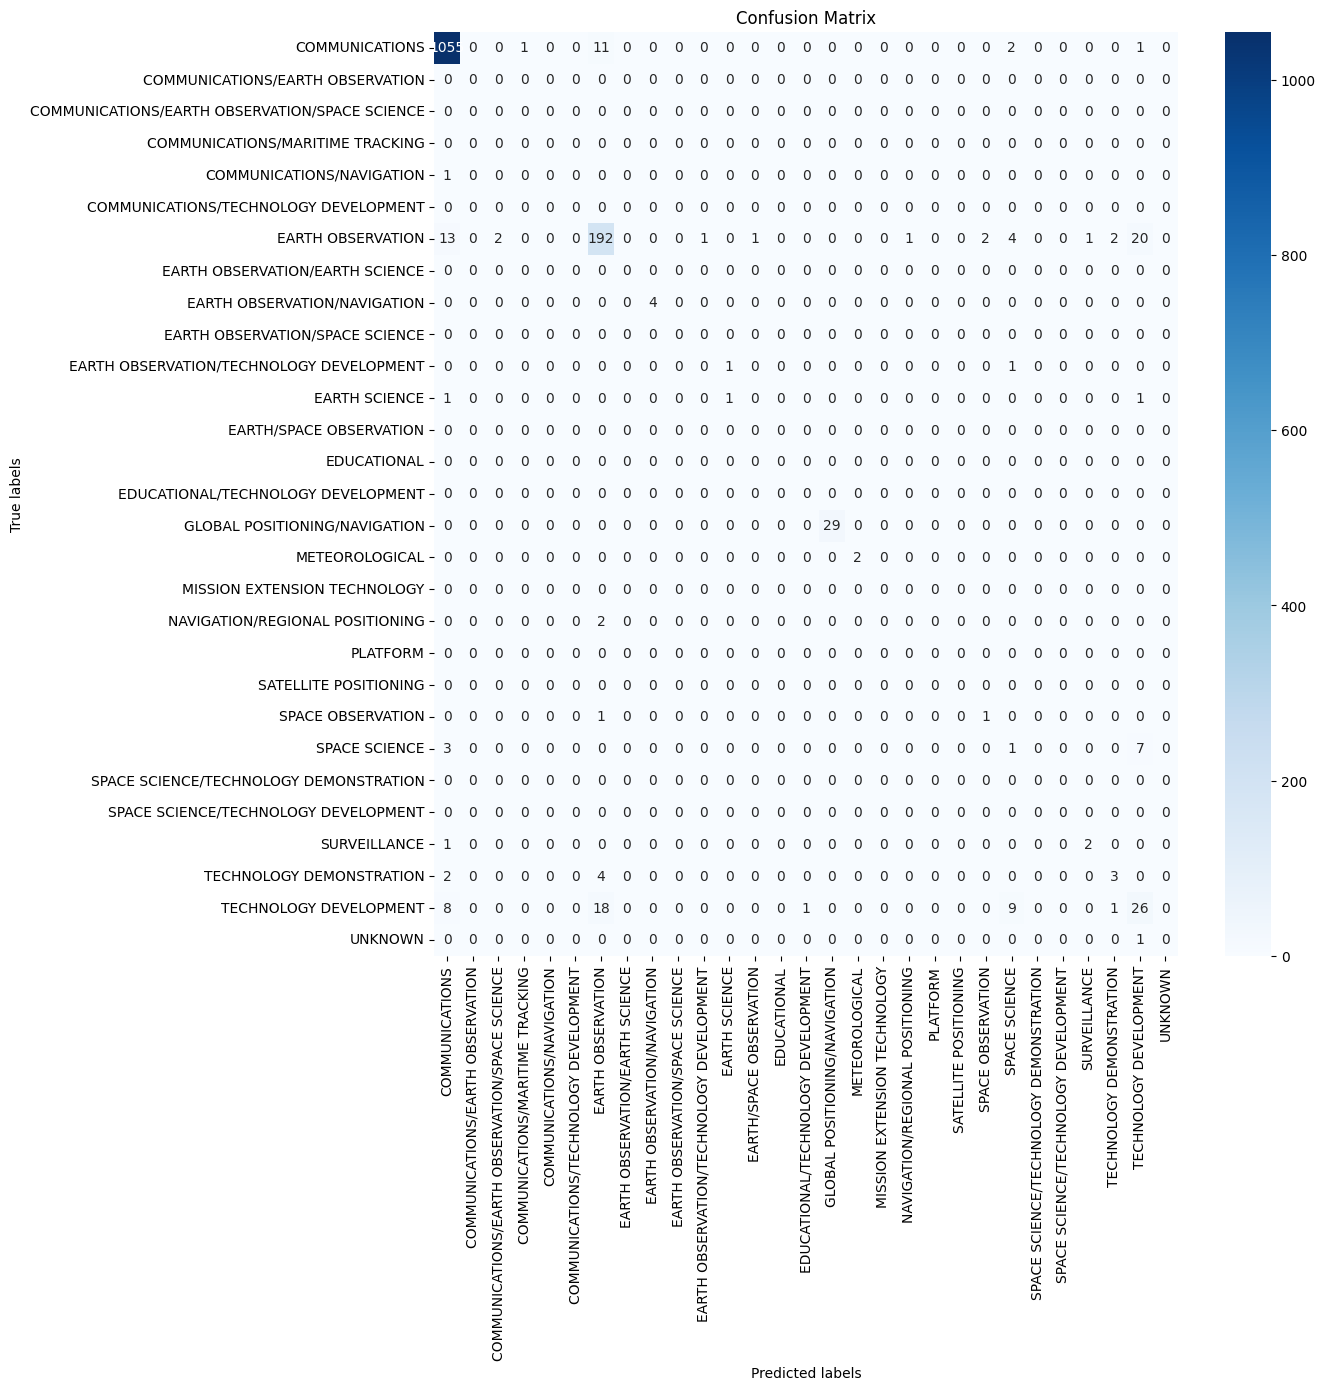

In [ ]:
build_and_eval_decision_tree(
    df = sat_df,
    df_name = 'sat_df',
    features = model_features,
    target = "Purpose_encoded",
    target_encoding=encoded_mappings['Purpose']
)



## Model Two - Streamlined Purpose Values

Looking at the evaluation from model one we see that we get about a 90% accuracy. But if we look at the confusion matrix, we see that a lot of the values are 0, which means a lot of these values aren't getting predicted. This makes sense if we look at the distribution of the Purpose values. Most of our satellites are classified as Communications, Earth Observation, or Technology Development. The rest of the categories have very few entries. So it makes sense that our initial model is biased toward correctly classifying the categories with the most values.



Column: Purpose
Type: category
Found 29 unique values


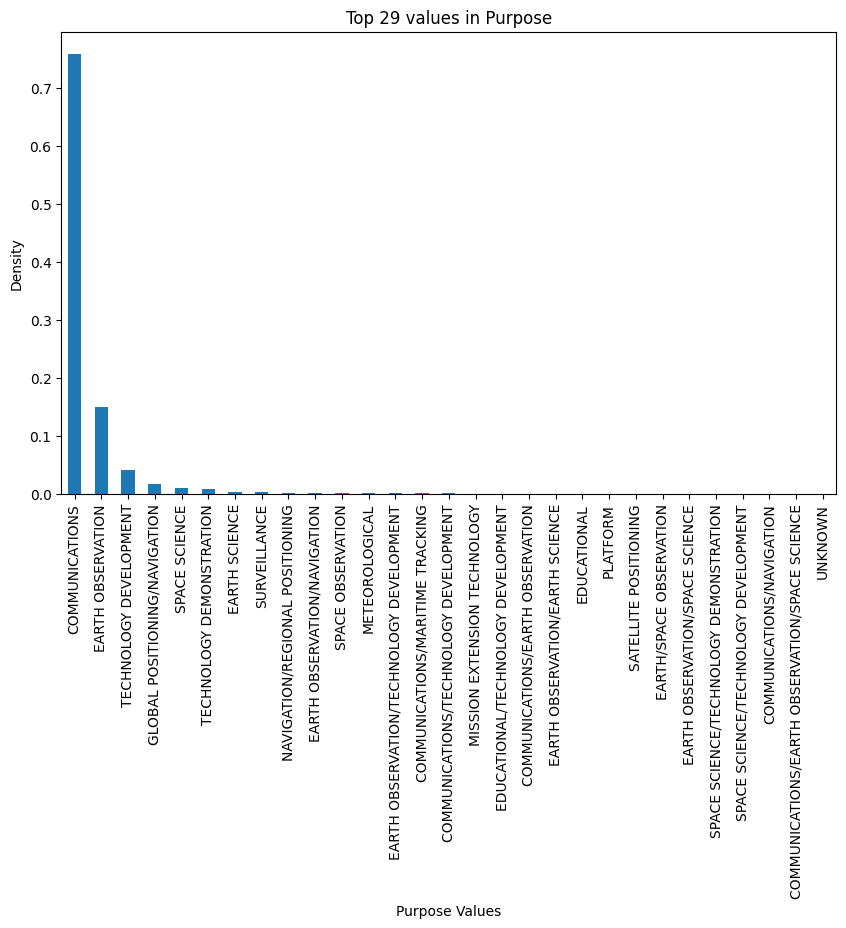

In [ ]:
column_overview(sat_df, 'Purpose', show_plot=True)

For the next model, I'm going to use a subset of the values. During preprocessing for the satelites that had multiple purposes, we added another attribute caled `Purpose_subset` and took the first purpose listed - this is making an assumption that the first value listed is the primary use. From the plot below we can see that the data are still overwhelmingly classified as being for communications, but the goal is to see if having fewer values to classify with helps the overall accuracy.

Column: Purpose_subset
Type: category
Found 16 unique values


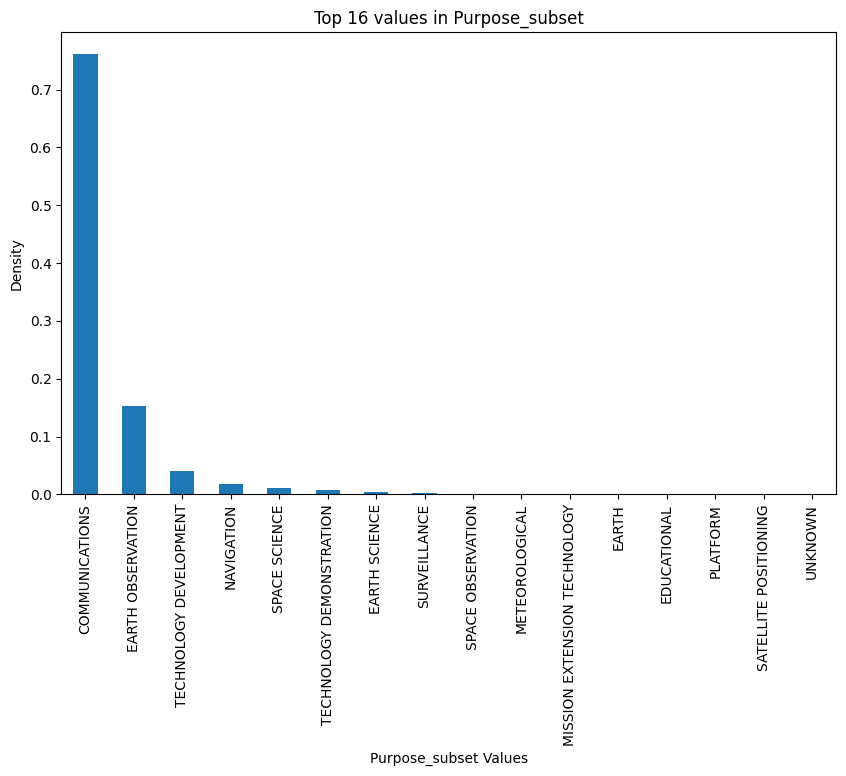

In [ ]:
column_overview(sat_df, 'Purpose_subset', show_plot=True)

Accuracy: 0.9146426092990978


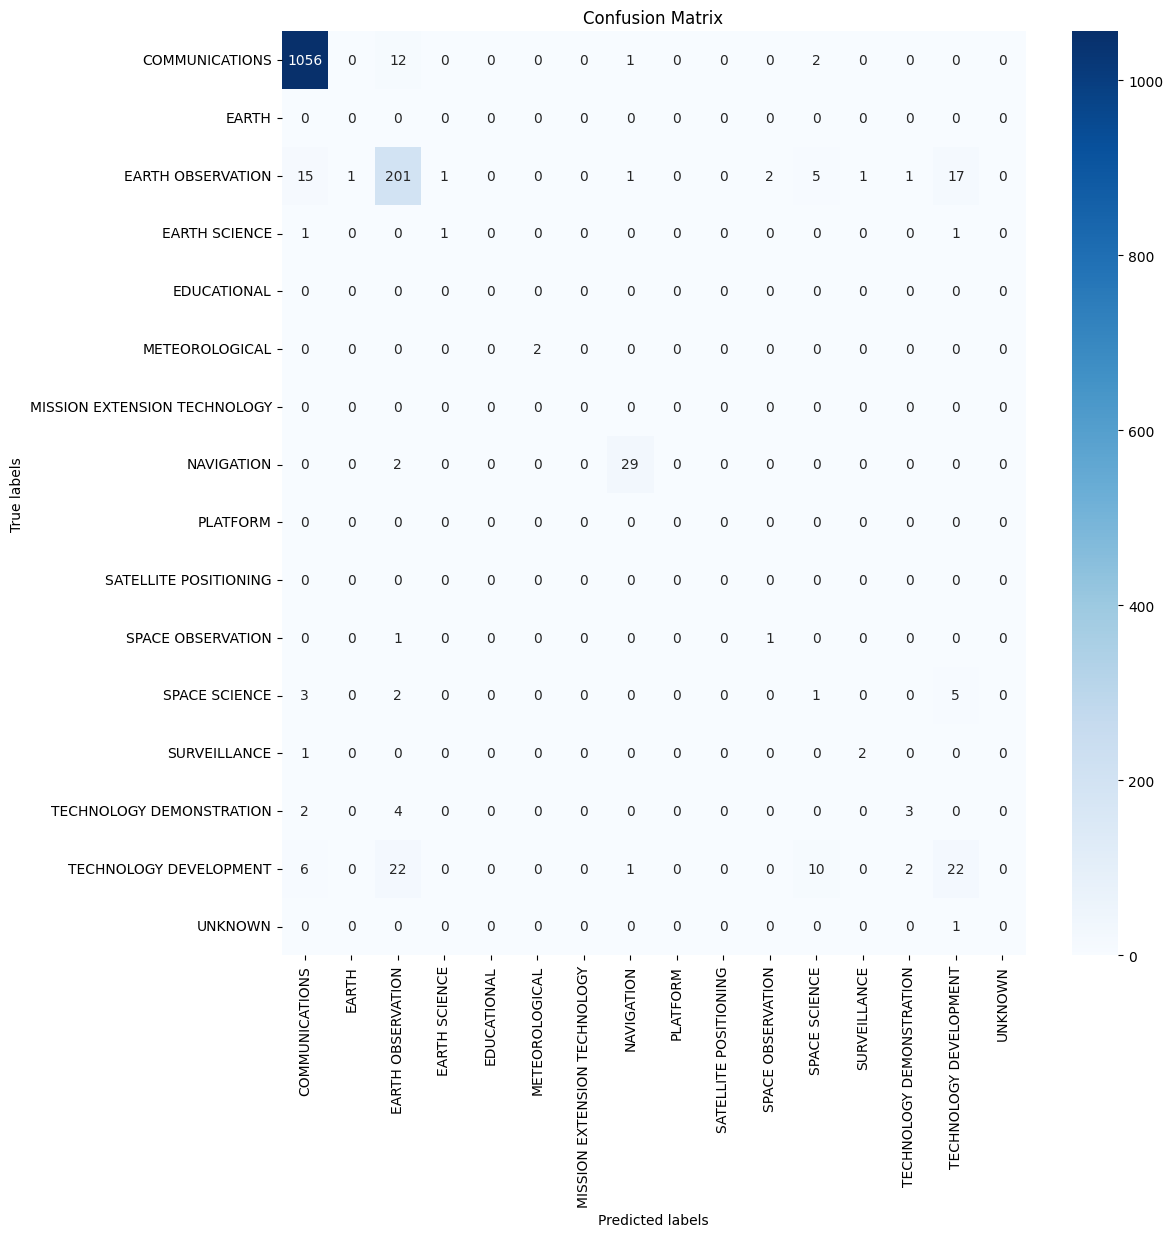

In [ ]:
build_and_eval_decision_tree(
    df = sat_df,
    df_name = 'sat_df',
    features = model_features,
    target = "Purpose_subset_encoded",
    target_encoding=encoded_mappings['Purpose_subset']
)

## Model Three - Five: Down-sampling Communications

The two models above have accuracy of about 90% each. However we see that there is still a pretty large bias in our model performance because there are so many Commmunications satellites. In this section, I'll try making models using three new datasets:
- Model with fewer COMMUNICATIONS satellites (will put it on par with the classification w/2nd highest density - EARTH OBSERVATION)
- Model with fewer COMMUNICATIONS and EARTH OBSERVATION satellites
- Model with no COMMUNICATIONS satellites

Column: Purpose
Type: category
Found 29 unique values


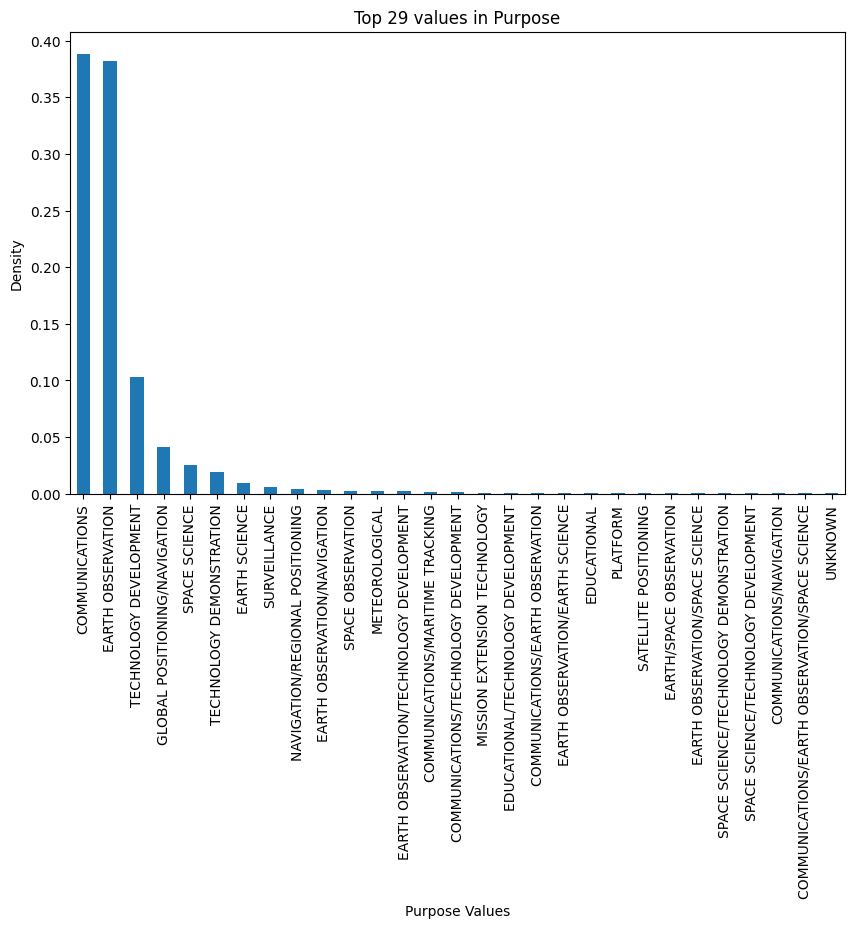

Accuracy: 0.798941798941799


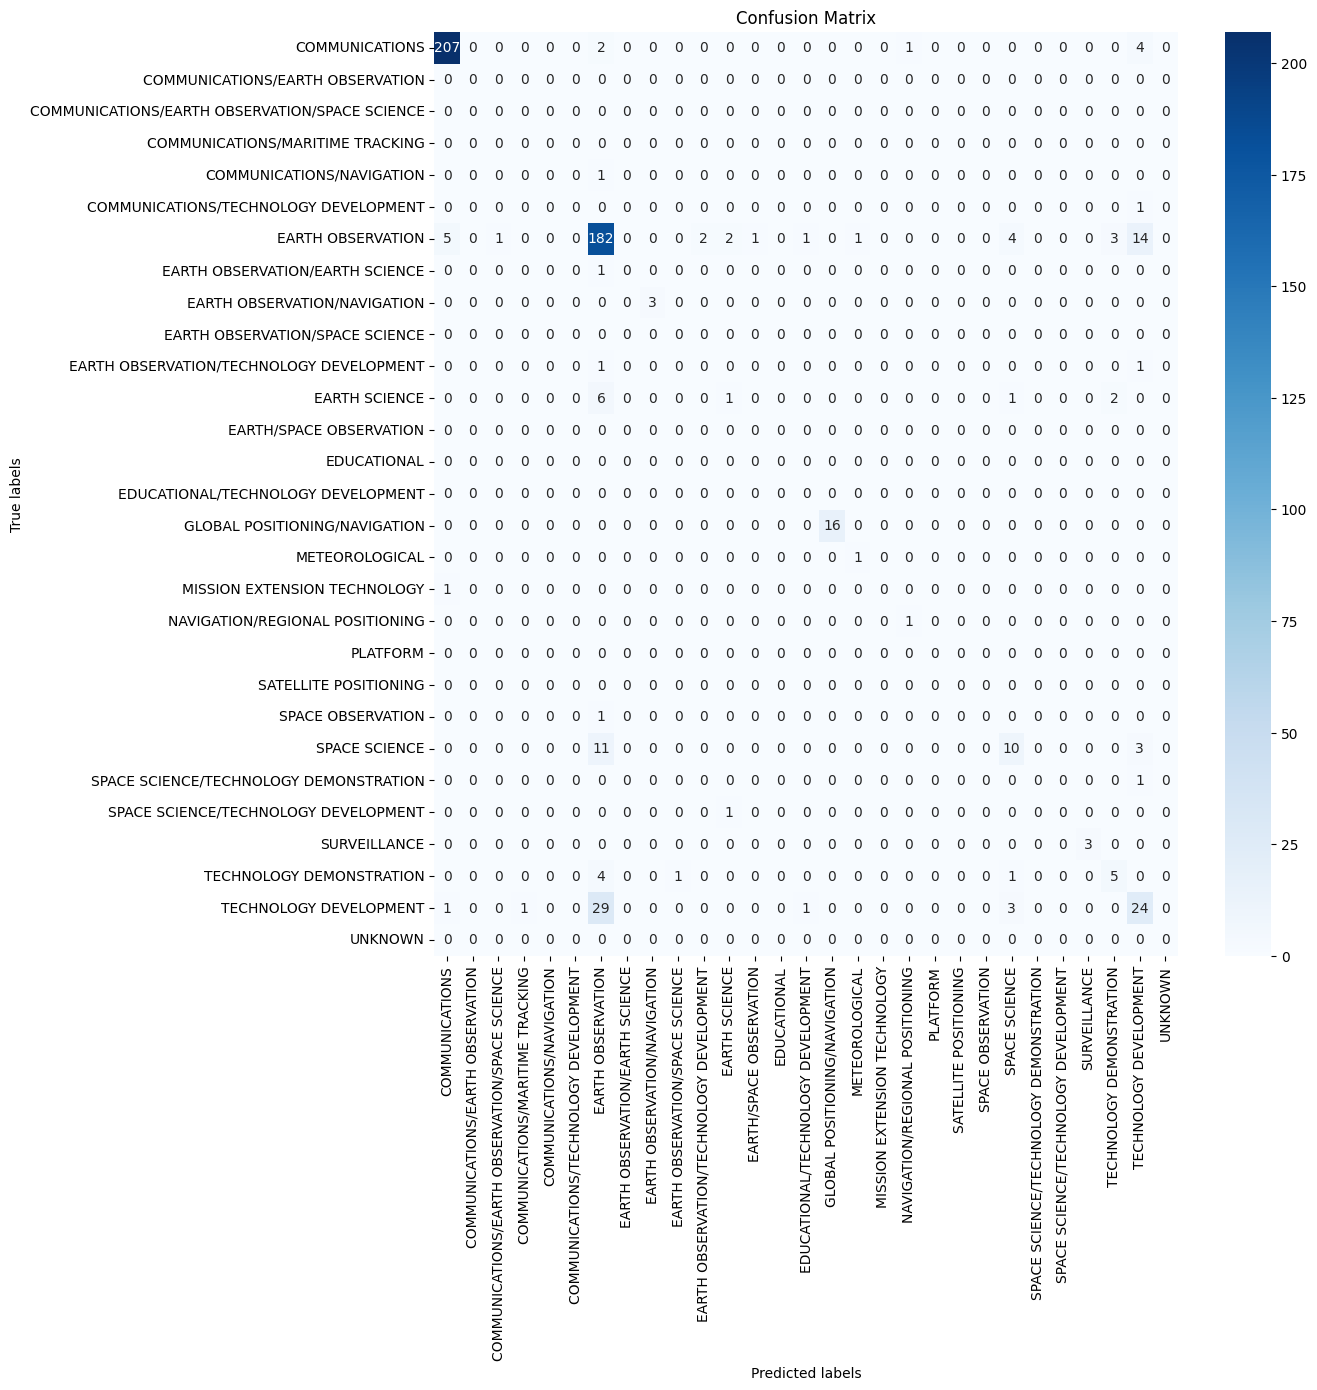

Accuracy: 0.8024691358024691


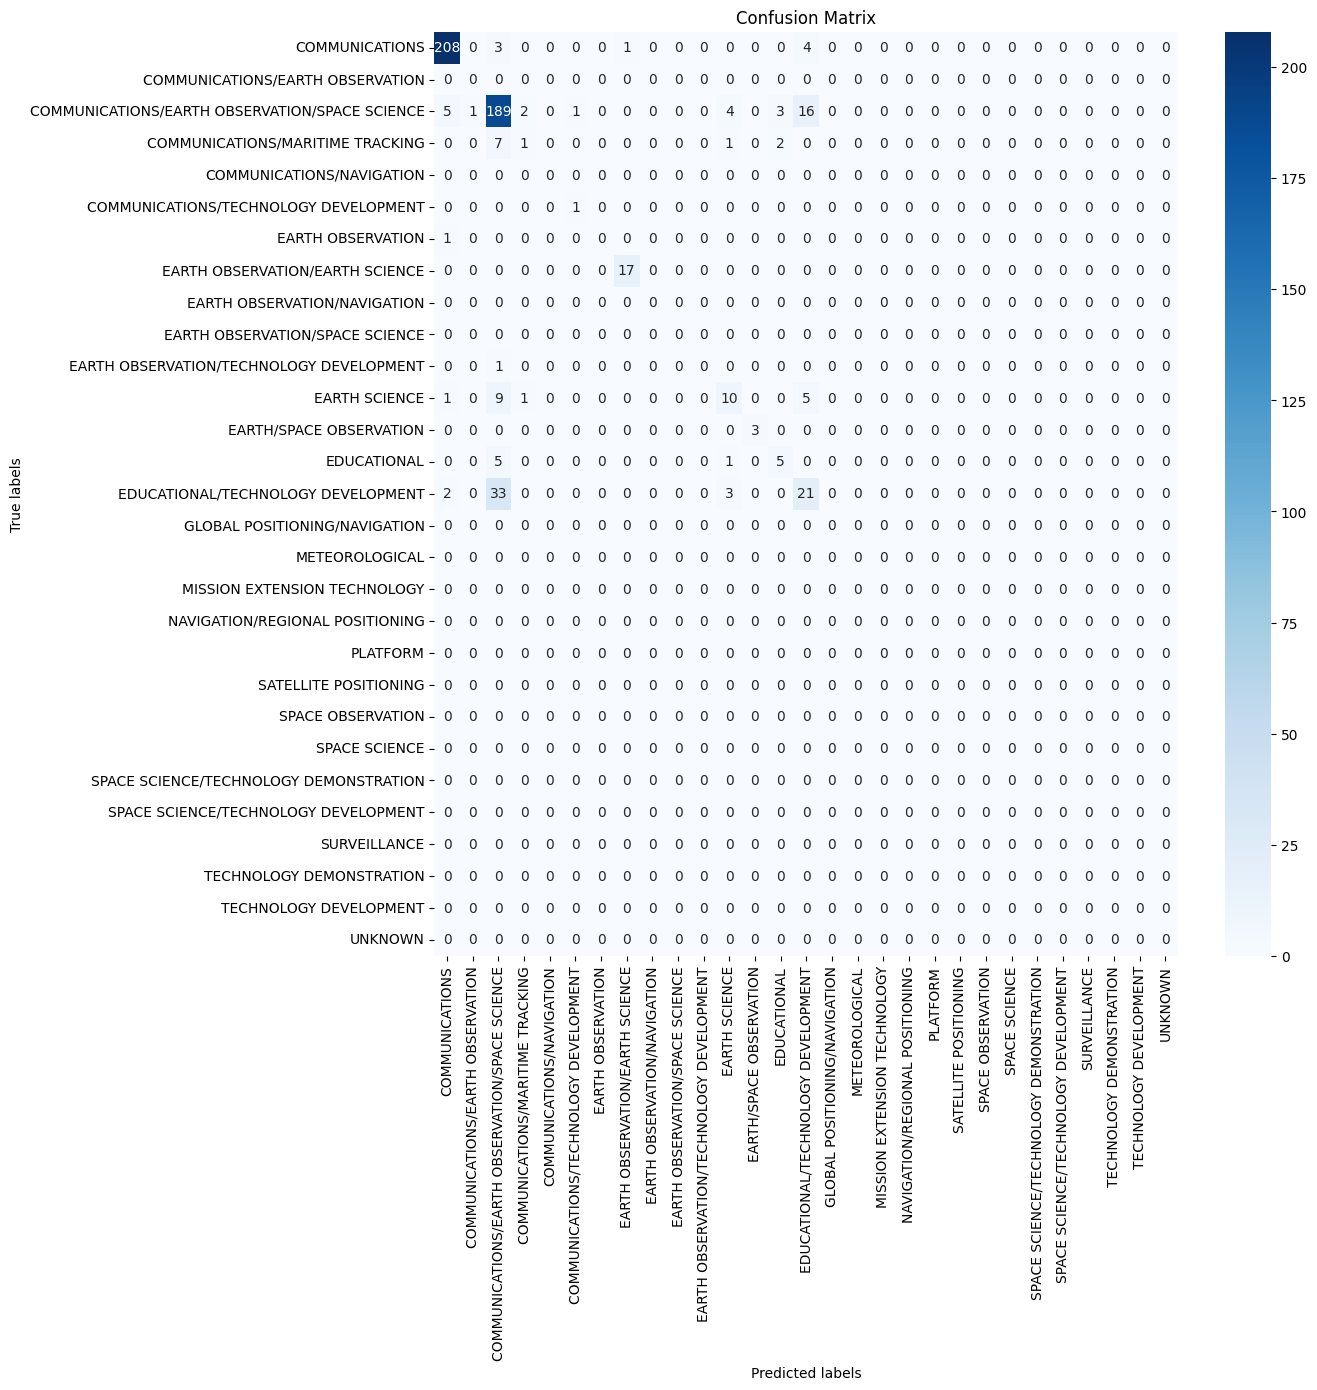

In [ ]:
downsampled_comms = pd.concat([
    sat_df[sat_df['Purpose'] != 'COMMUNICATIONS'],  # Keep all rows except COMMUNICATIONS
    sat_df[sat_df['Purpose'] == 'COMMUNICATIONS'].sample(n=1100, random_state=55)  # some from COMMUNICATIONS
])

column_overview(downsampled_comms, 'Purpose', show_plot=True)

build_and_eval_decision_tree(
    df = downsampled_comms,
    df_name = 'downsampled_comms',
    features = model_features,
    target = "Purpose_encoded",
    target_encoding=encoded_mappings['Purpose']
)
build_and_eval_decision_tree(
    df = downsampled_comms,
    df_name = 'downsampled_comms',
    features = model_features,
    target = "Purpose_subset_encoded",
    target_encoding=encoded_mappings['Purpose']
)

Column: Purpose
Type: category
Found 29 unique values


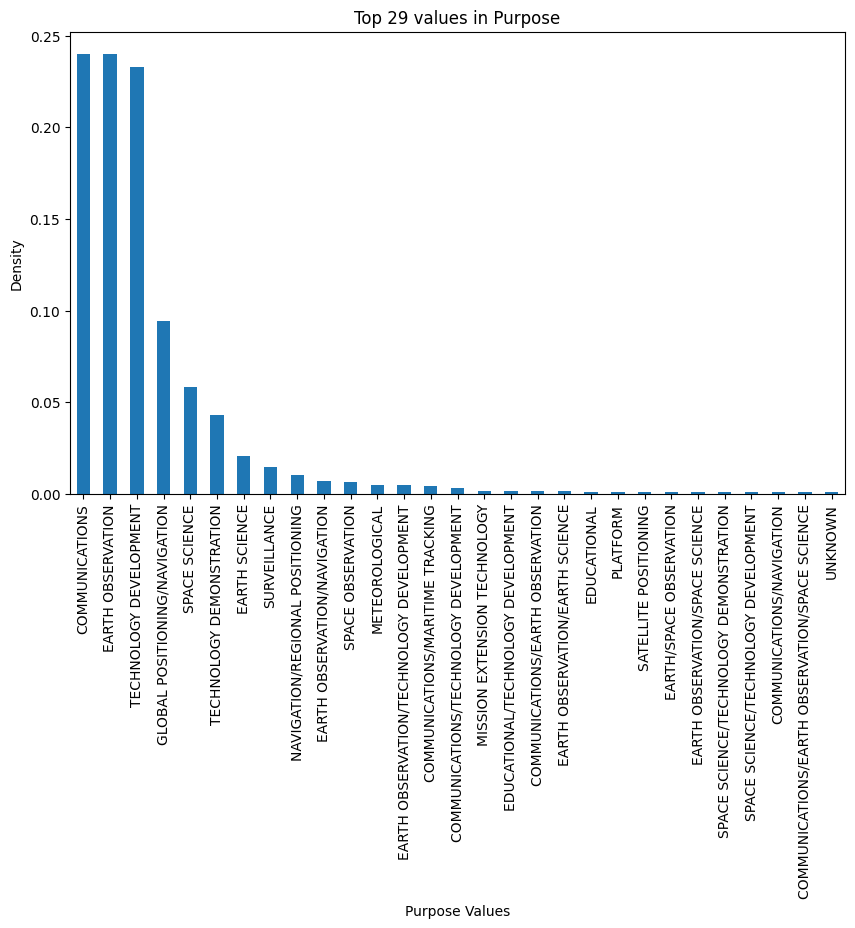

Accuracy: 0.708


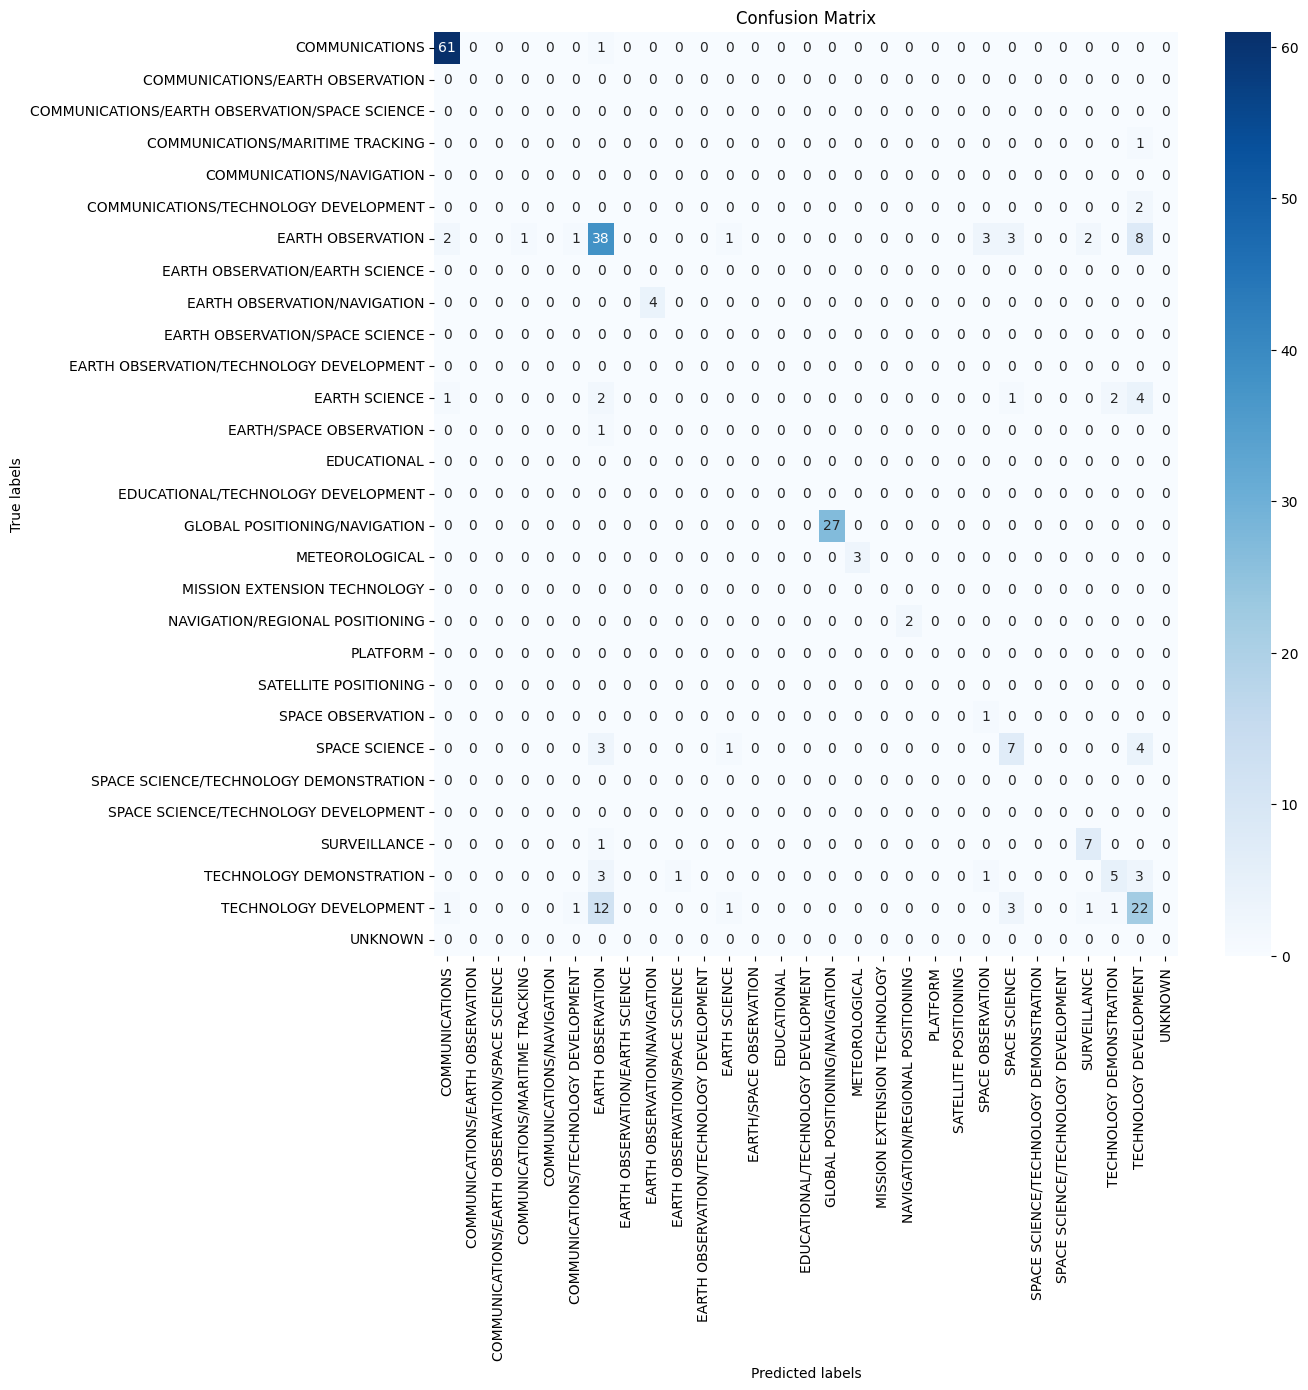

Accuracy: 0.704


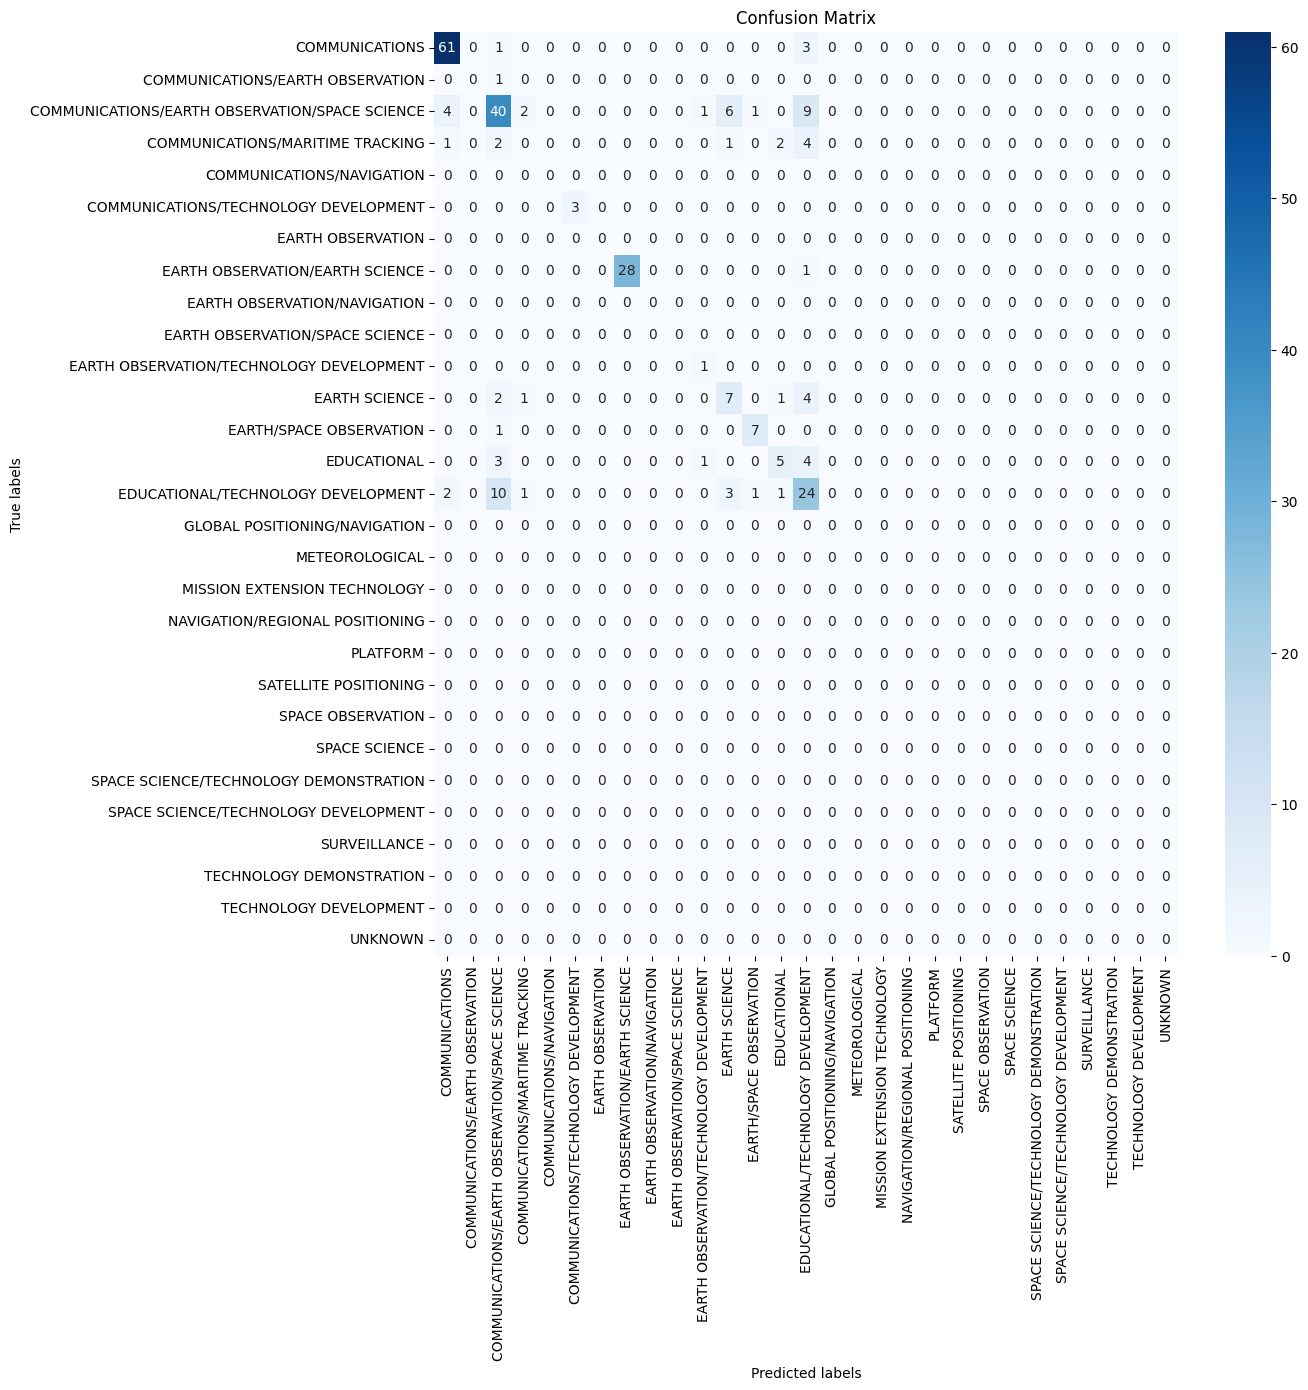

In [ ]:
downsampled_comms_and_eo = pd.concat([
    sat_df[(sat_df['Purpose'] != 'COMMUNICATIONS') & (sat_df['Purpose'] != 'EARTH OBSERVATION')],  # Keep all rows except COMMUNICATIONS and EARTH OBSERVATION
    sat_df[sat_df['Purpose'] == 'COMMUNICATIONS'].sample(n=300, random_state=55),  # Sample from COMMUNICATIONS
    sat_df[sat_df['Purpose'] == 'EARTH OBSERVATION'].sample(n=300, random_state=55)  # Sample from EARTH OBSERVATION
])

column_overview(downsampled_comms_and_eo, 'Purpose', show_plot=True)

build_and_eval_decision_tree(
    df = downsampled_comms_and_eo,
    df_name= 'downsampled_comms_and_eo',
    features = model_features,
    target = "Purpose_encoded",
    target_encoding=encoded_mappings['Purpose']
)
build_and_eval_decision_tree(
    df = downsampled_comms_and_eo,
    df_name= 'downsampled_comms_and_eo',
    features = model_features,
    target = "Purpose_subset_encoded",
    target_encoding=encoded_mappings['Purpose']
)

Column: Purpose
Type: category
Found 28 unique values


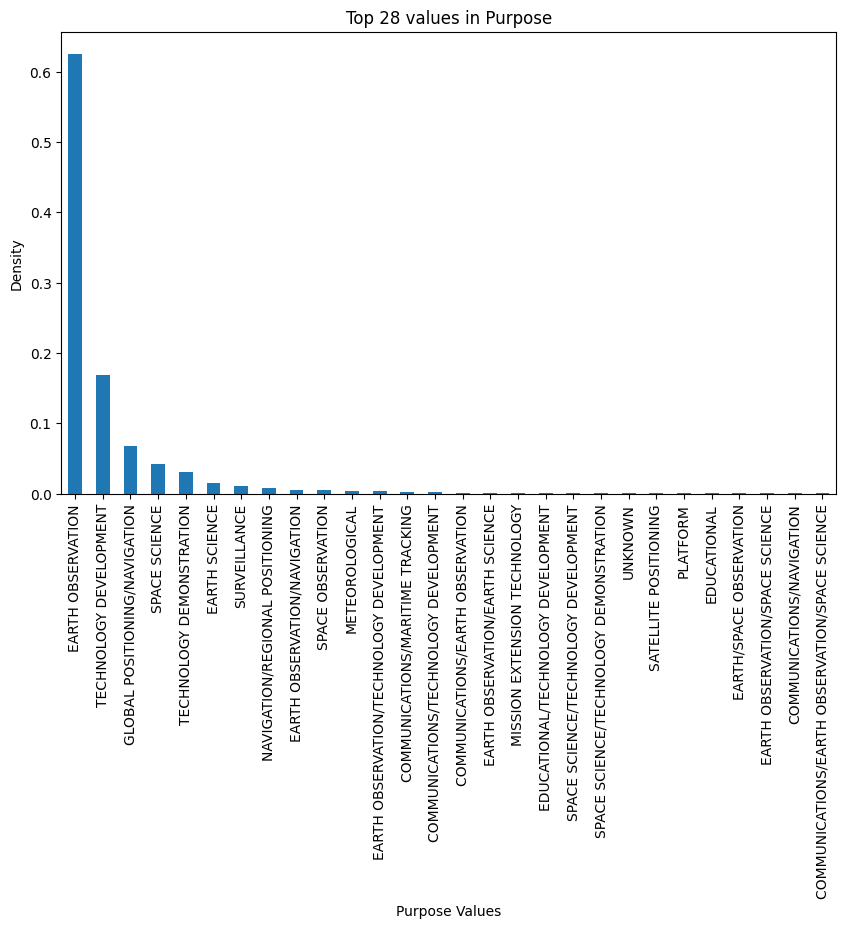

Accuracy: 0.729106628242075


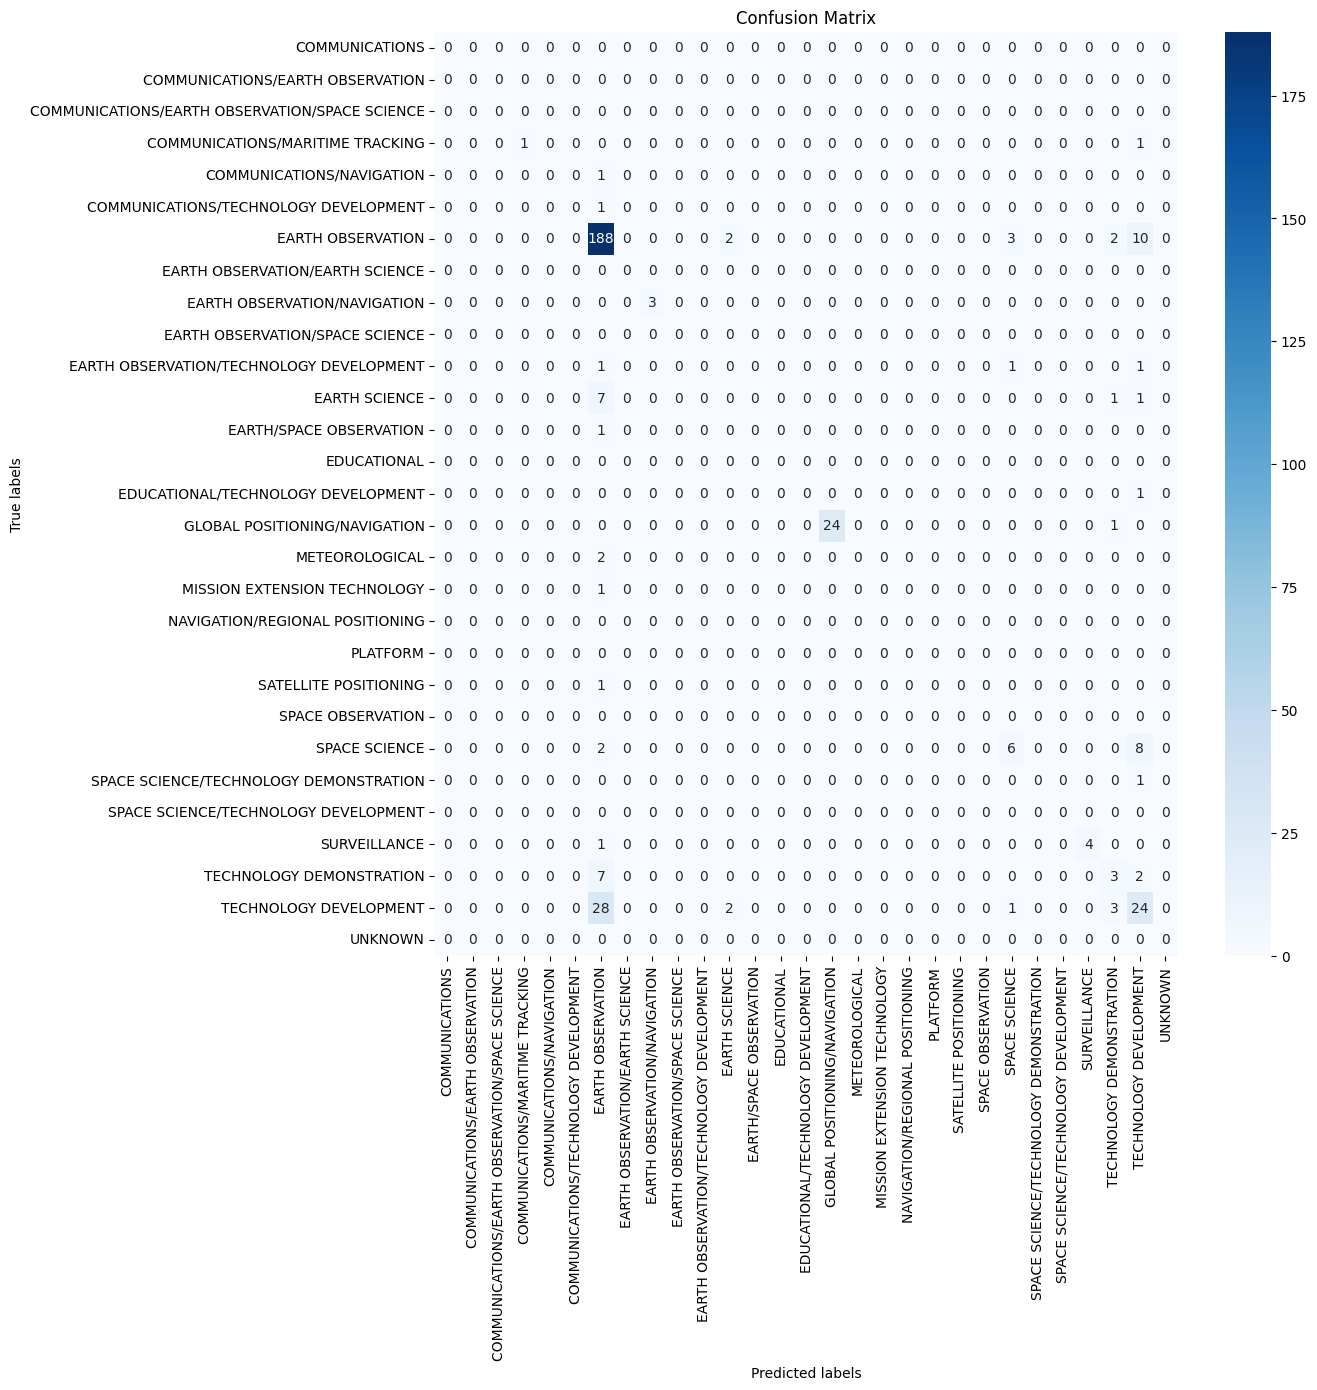

Accuracy: 0.7204610951008645


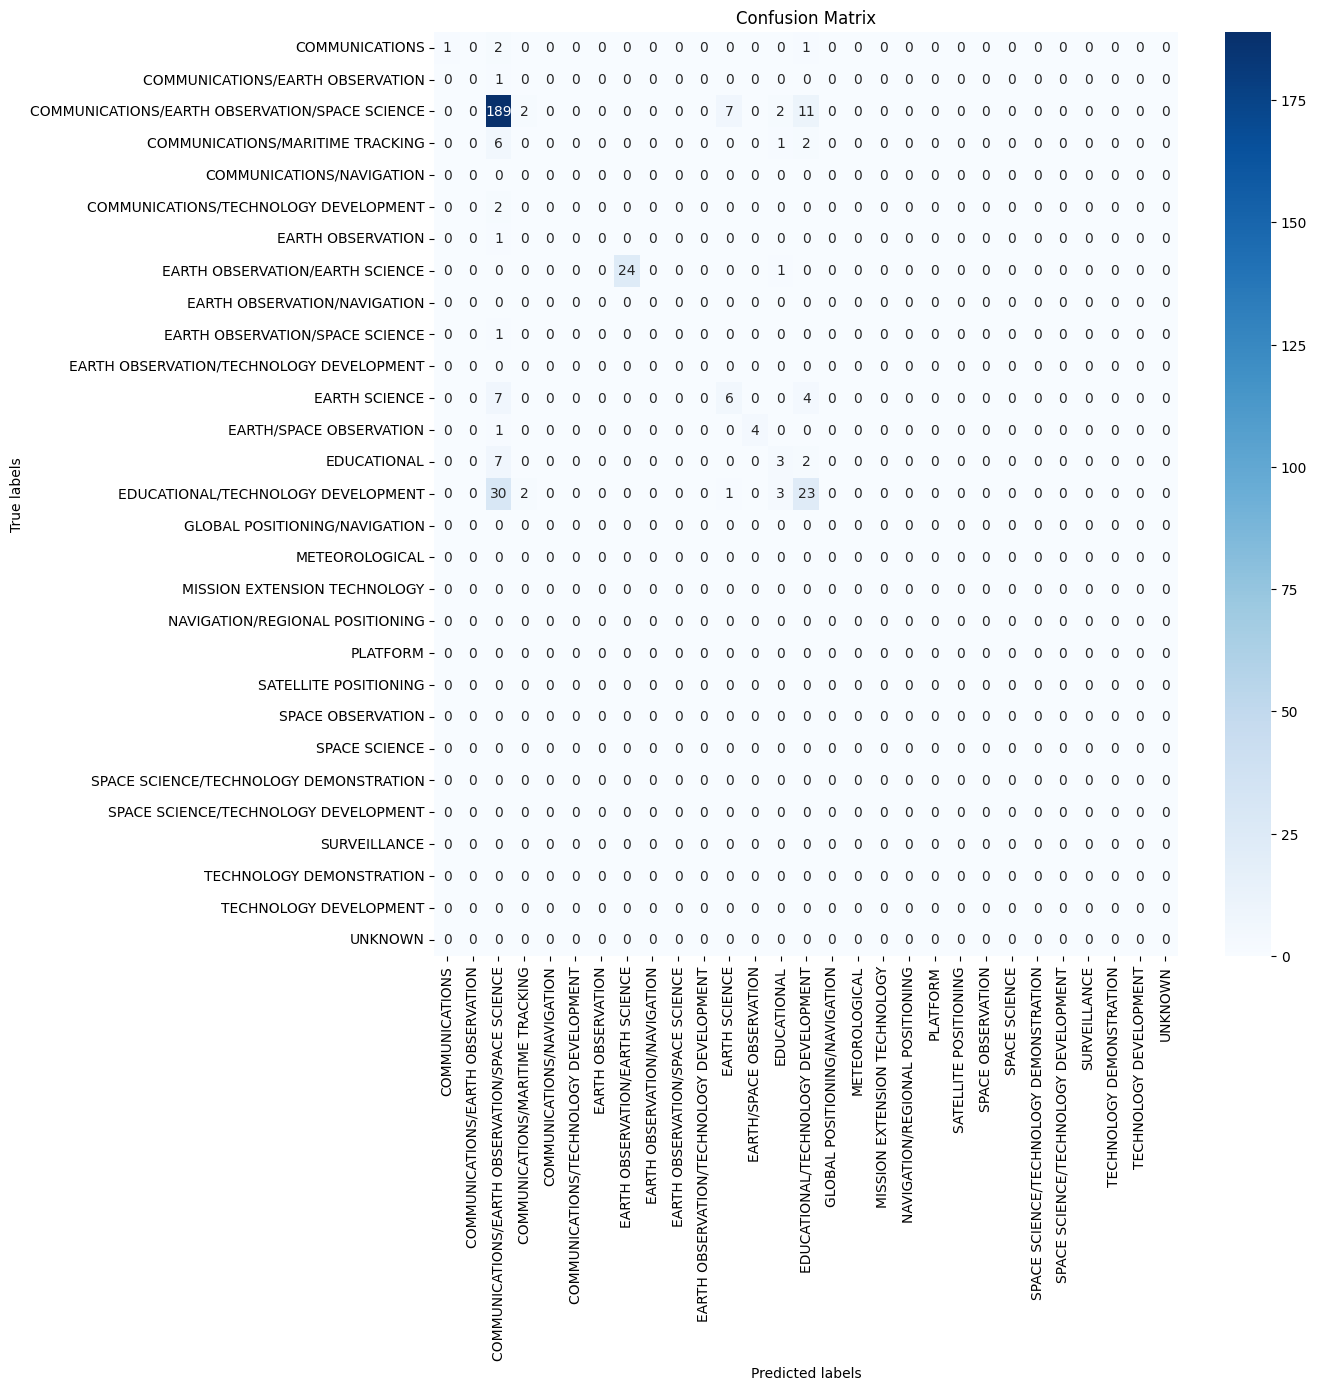

In [ ]:
no_comms =  sat_df[sat_df['Purpose'] != 'COMMUNICATIONS']
column_overview(no_comms, 'Purpose', show_plot=True)

build_and_eval_decision_tree(
    df = no_comms,
    df_name= 'no_comms',
    features = model_features,
    target = "Purpose_encoded",
    target_encoding=encoded_mappings['Purpose']
)

build_and_eval_decision_tree(
    df = no_comms,
    df_name= 'no_comms',
    features = model_features,
    target = "Purpose_subset_encoded",
    target_encoding=encoded_mappings['Purpose']
)

## KNN Models

In this section we'll use the same features and datasets as we did with the Decision Tree models but instead with KNN models so we can compare the results. K-Nearest Neighbors (KNN) is another supervised learning model, that classifies a new data point based which where the majority of its nearest neighbors that it's closest to lie in the feature space. In general KNN models work best when the data is numerical. Though we've encoded our categorical variables, I'd expect the overall performance to be worse as compared to the Decision Trees, but let's find out.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import math

def build_and_eval_knn(df: pd.DataFrame, df_name: str, features: List[str], target: str):
  X = df[features]
  y = df[target]
  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
  k = int(math.sqrt(len(X_train)))

  # Create a KNN classifier with k=3
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the classifier on the training data
  knn.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = knn.predict(X_test)

  # Calculate the accuracy of the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

  add_to_results(
    df_name = df_name,
    model = knn,
    model_type = "KNN",
    features=features,
    target = target,
    accuracy = accuracy
  )

Accuracy: 0.8688410825815406


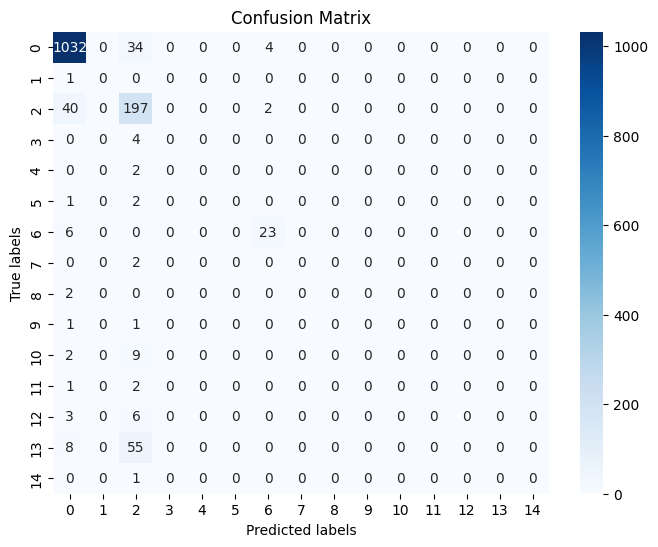

In [ ]:
build_and_eval_knn(sat_df, 'sat_df', model_features, 'Purpose_encoded')

Accuracy: 0.7248677248677249


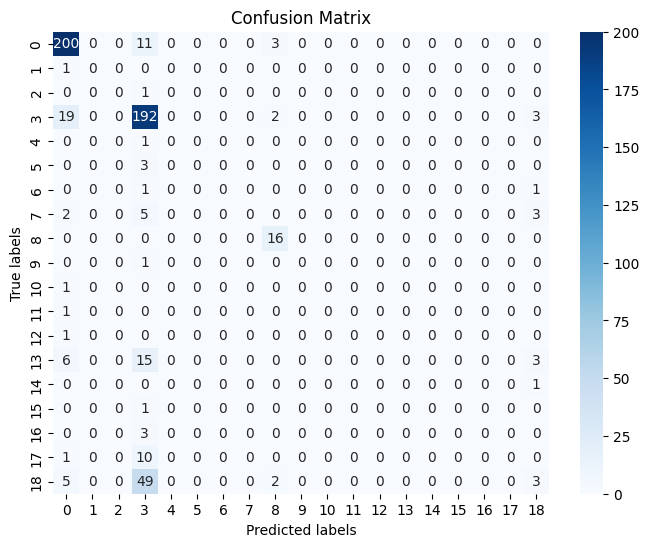

Accuracy: 0.58


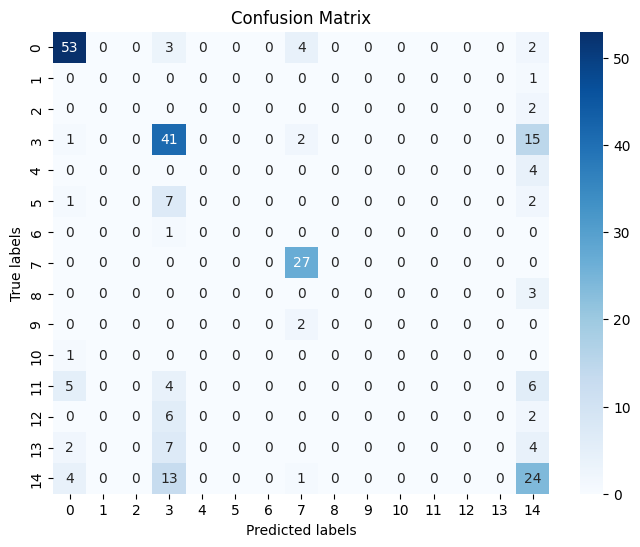

Accuracy: 0.6657060518731989


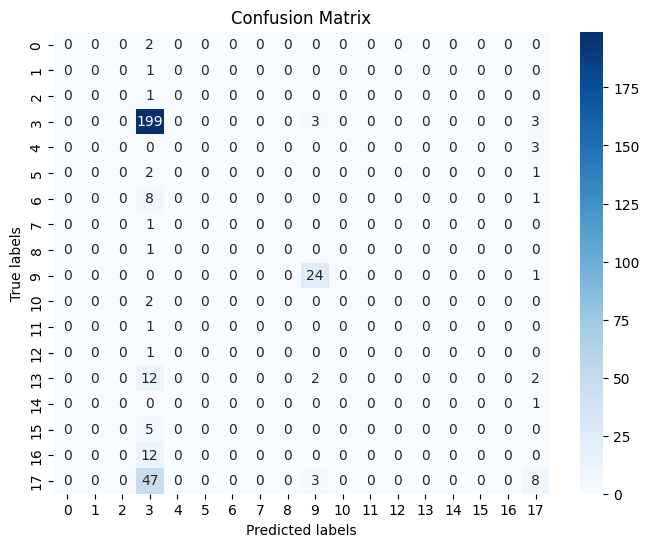

In [ ]:
build_and_eval_knn(downsampled_comms, 'downsampled_comms', model_features, 'Purpose_encoded')
build_and_eval_knn(downsampled_comms_and_eo, 'downsampled_comms_and_eo', model_features, 'Purpose_encoded')
build_and_eval_knn(no_comms, 'no_comms', model_features, 'Purpose_encoded')

Accuracy: 0.7336860670194003


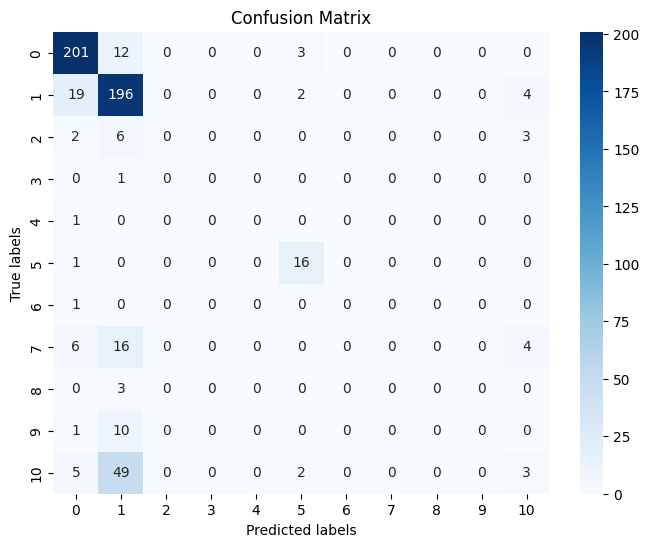

Accuracy: 0.6


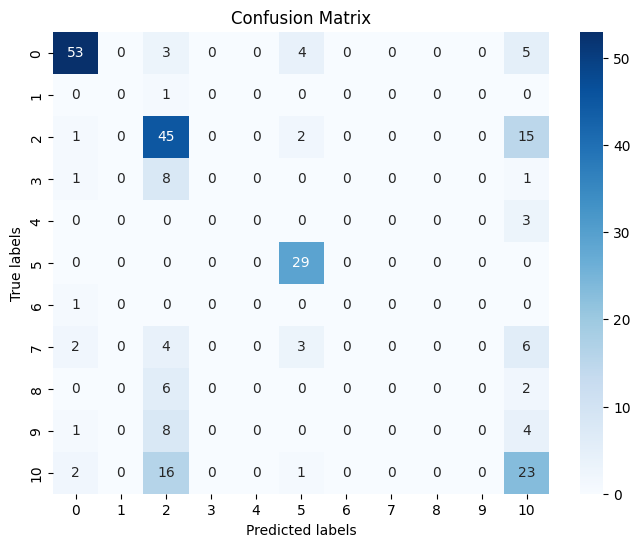

Accuracy: 0.6772334293948127


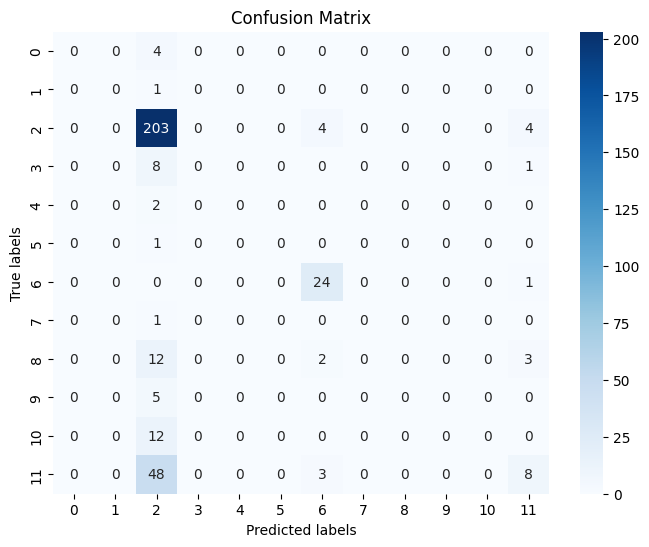

In [ ]:
build_and_eval_knn(downsampled_comms, 'downsampled_comms', model_features, 'Purpose_subset_encoded')
build_and_eval_knn(downsampled_comms_and_eo, 'downsampled_comms_and_eo', model_features, 'Purpose_subset_encoded')
build_and_eval_knn(no_comms, 'no_comms', model_features, 'Purpose_subset_encoded')

# Step Four: Results and Analysis

In [ ]:
results_sorted = results.sort_values(by='Accuracy', ascending=False)
results_sorted.head(15)

DataFrame          Model  \
1                     sat_df  Decision Tree   
0                     sat_df  Decision Tree   
8                     sat_df            KNN   
3          downsampled_comms  Decision Tree   
2          downsampled_comms  Decision Tree   
12         downsampled_comms            KNN   
6                   no_comms  Decision Tree   
9          downsampled_comms            KNN   
7                   no_comms  Decision Tree   
4   downsampled_comms_and_eo  Decision Tree   
5   downsampled_comms_and_eo  Decision Tree   
14                  no_comms            KNN   
11                  no_comms            KNN   
13  downsampled_comms_and_eo            KNN   
10  downsampled_comms_and_eo            KNN   

                                             Features                  Target  \
1   [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
0   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
8   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
3   [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
2   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
12  [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
6   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
9   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
7   [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
4   [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
5   [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
14  [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
11  [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   
13  [Type of Orbit_encoded, Launch Vehicle_encoded...  Purpose_subset_encoded   
10  [Type of Orbit_encoded, Launch Vehicle_encoded...         Purpose_encoded   

    Accuracy  
1   0.914643  
0   0.913255  
8   0.868841  
3   0.802469  
2   0.798942  
12  0.733686  
6   0.729107  
9   0.724868  
7   0.720461  
4   0.708000  
5   0.704000  
14  0.677233  
11  0.665706  
13  0.600000  
10  0.580000

In the previous section, we built multiple models using two supervised methods: K-Nearest Neighbors (KNN) and Decision Trees. The table above shows the results summary from the evaluation of the models built. Accuracy in predicting the Satellite's purpose was used as the key metric used for evaluating performance.

After experimenting with various combinations of features, I found that the optimal feature set for the Decision Tree model was 'Type of Orbit_encoded', 'Launch Vehicle_encoded', 'Users_encoded', 'Period (minutes)'. Using this feature set, along with the full dataset and the full list of Purpose target values, resulted generally in the highest performance of just over 90%. Interestingly, using the subsets of the Purpose target values (that excluded multiple classification) performed comparably to using the full set.

However, the high accuracy of those models was likely influenced by bias in the data, particularly towards communications satellites. As we can see after downsampling the number of communications satellites in the training set, the accuracy dropped to the 80s and below. Complete removal of communications points led to an accuracy of about 70%. This indicates that we are not quite as good at predicting the outcome of non-communications satellites.

When applying the same model parameters to the KNN method, we confirm that KNN performed worse overall. This was expected though, as KNN is typically more suited for numerical data rather than categorical data, despite the text-based data being encoded.

These results highlight the importance of both model selection and unbiased data in improving the accuracy and reliability of classification models. The decision tree model, with its ability to handle both categorical and numerical data effectively, proved to be better suited for this classification task than the KNN model.

# Step Five: Conclusions


As we can see from the previous results section, the decision tree model proved effective, achieving high performance with an optimal feature set 'Type of Orbit_encoded', 'Launch Vehicle_encoded', 'Users_encoded', 'Period (minutes)' and using the full dataset and full list of Purpose target values.

The analysis also revealed challenges with biased training data - particularly towards communications points. This bias was likely the heaviest influence the high accuracy achieved by the initial models. Downsampling the communications data to mitigate bias led to a decrease in accuracy, underscored the complexities of working with biased data in classification tasks.

For possible future work, exploring different methods to mitigate bias in the data will be important for improving performance. For example trying different resampling techniques or maybe new supervised methods, Random Forests may help improve performance. Additionally, it may make sense to identify optimal feature sets for downsampled/resampled data as well.

Overall, while we faced challenges with biased data, it lays the foundation for future research into improving satellite classification models through better data handling and model selection techniques.